# 1. Imports y configuraciones

In [1]:
!jupyter --version

Selected Jupyter core packages...
IPython          : 8.4.0
ipykernel        : 6.15.1
ipywidgets       : 7.7.1
jupyter_client   : 7.3.4
jupyter_core     : 4.11.1
jupyter_server   : not installed
jupyterlab       : not installed
nbclient         : 0.6.6
nbconvert        : 6.5.0
nbformat         : 5.4.0
notebook         : 6.4.12
qtconsole        : 5.3.1
traitlets        : 5.3.0


In [2]:
import datetime
from pathlib import Path
from typing import Any

import airportsdata as airdata
import folium
import lightgbm as lgbm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from folium.plugins import MarkerCluster
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import (roc_auc_score, classification_report, confusion_matrix)
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC

sns.set_theme()

# 2. Exploratory Data Analysis (EDA)
## 2.1 Leer dataset

In [3]:
data = pd.read_csv(Path().joinpath('data', 'dataset_SCL.csv'))

C:\Users\Admin\AppData\Local\Temp\ipykernel_11460\2557340355.py:1: DtypeWarning: Columns (1,6) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(Path().joinpath('data', 'dataset_SCL.csv'))


## 2.2 Chequear y corregir data types

De acuerdo a la documentación del desafío, las columnas son las siguientes:

- Fecha-I : Fecha y hora programada del vuelo. &rarr; **datetime**
- Vlo-I : Número de vuelo programado. &rarr; **integer**
- Ori-I : Código de ciudad de origen programado. &rarr; **string**
- Des-I : Código de ciudad de destino programado. &rarr; **string**
- Emp-I : Código aerolínea de vuelo programado. &rarr; **string**
- Fecha-O : Fecha y hora de operación del vuelo. &rarr; **datetime**
- Vlo-O : Número de vuelo de operación del vuelo. &rarr; **integer**
- Ori-O : Código de ciudad de origen de operación. &rarr; **string**
- Des-O : Código de ciudad de destino de operación. &rarr; **string**
- Emp-O : Código aerolínea de vuelo operado. &rarr; **string**
- DIA : Día del mes de operación del vuelo. &rarr; **integer**
- MES : Número de mes de operación del vuelo. &rarr; **integer**
- AÑO : Año de operación del vuelo. &rarr; **integer**
- DIANOM : Día de la semana de operación del vuelo. &rarr; **string**
- TIPOVUELO : Tipo de vuelo, I =Internacional, N =Nacional. &rarr; **string (binary)**
- OPERA : Nombre de aerolínea que opera. &rarr; **string**
- SIGLAORI : Nombre ciudad origen. &rarr; **string**
- SIGLADES : Nombre ciudad destino. &rarr; **string**

In [4]:
print(data.info())
data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68206 entries, 0 to 68205
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Fecha-I    68206 non-null  object
 1   Vlo-I      68206 non-null  object
 2   Ori-I      68206 non-null  object
 3   Des-I      68206 non-null  object
 4   Emp-I      68206 non-null  object
 5   Fecha-O    68206 non-null  object
 6   Vlo-O      68205 non-null  object
 7   Ori-O      68206 non-null  object
 8   Des-O      68206 non-null  object
 9   Emp-O      68206 non-null  object
 10  DIA        68206 non-null  int64 
 11  MES        68206 non-null  int64 
 12  AÑO        68206 non-null  int64 
 13  DIANOM     68206 non-null  object
 14  TIPOVUELO  68206 non-null  object
 15  OPERA      68206 non-null  object
 16  SIGLAORI   68206 non-null  object
 17  SIGLADES   68206 non-null  object
dtypes: int64(3), object(15)
memory usage: 9.4+ MB
None


,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68201,2017-12-22 14:55:00,400,SCEL,SPJC,JAT,2017-12-22 15:41:00,400.0,SCEL,SPJC,JAT,22,12,2017,Viernes,I,JetSmart SPA,Santiago,Lima
68202,2017-12-25 14:55:00,400,SCEL,SPJC,JAT,2017-12-25 15:11:00,400.0,SCEL,SPJC,JAT,25,12,2017,Lunes,I,JetSmart SPA,Santiago,Lima
68203,2017-12-27 14:55:00,400,SCEL,SPJC,JAT,2017-12-27 15:35:00,400.0,SCEL,SPJC,JAT,27,12,2017,Miercoles,I,JetSmart SPA,Santiago,Lima
68204,2017-12-29 14:55:00,400,SCEL,SPJC,JAT,2017-12-29 15:08:00,400.0,SCEL,SPJC,JAT,29,12,2017,Viernes,I,JetSmart SPA,Santiago,Lima


Al parecer hay columnas con más de un tipo de dato, veamos cuales.

*Obs: Los códigos de aeropuerto están en formato ICAO.*

In [5]:
for i in data.columns:
    print(i, data[i].apply(lambda a: type(a).__name__).value_counts().to_dict())

Fecha-I {'str': 68206}
Vlo-I {'str': 65536, 'int': 2670}
Ori-I {'str': 68206}
Des-I {'str': 68206}
Emp-I {'str': 68206}
Fecha-O {'str': 68206}
Vlo-O {'str': 65535, 'float': 2671}
Ori-O {'str': 68206}
Des-O {'str': 68206}
Emp-O {'str': 68206}
DIA {'int': 68206}
MES {'int': 68206}
AÑO {'int': 68206}
DIANOM {'str': 68206}
TIPOVUELO {'str': 68206}
OPERA {'str': 68206}
SIGLAORI {'str': 68206}
SIGLADES {'str': 68206}


Las columnas 'Vlo-I' y 'Vlo-O' tienen mezclados int/float y str, por lo que se transformarán a int solamente ya que representan números de vuelo. Adicionalmente, las columnas de fecha son strings pero deberían convertirse a datetime.

In [6]:
data = data.convert_dtypes()  # Cast object to str where possible
data[['Fecha-I', 'Fecha-O']] = data[['Fecha-I', 'Fecha-O']].apply(pd.to_datetime, format='%Y-%m-%d %H:%M:%S')

Como los valores que se convertirán a int vienen como str, no necesariamente se podrán convertir por lo que hay que chequear que sean correctos

In [7]:
# Check which rows can't be cast from str to number
not_numeric_1 = data['Vlo-I'].apply(pd.to_numeric, errors='coerce').isna()
not_numeric_2 = data['Vlo-O'].apply(pd.to_numeric, errors='coerce').isna()
not_numeric = (not_numeric_1 | not_numeric_2)
data.loc[not_numeric]

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
6068,2017-01-19 11:00:00,200,SCEL,SPJC,LAW,2017-01-19 11:03:00,NaN,SCEL,SPJC,56R,19,1,2017,Jueves,I,Latin American Wings,Santiago,Lima
13906,2017-03-30 10:30:00,71,SCEL,SCIE,SKU,2017-03-30 10:50:00,71R,SCEL,SCIE,SKU,30,3,2017,Jueves,N,Sky Airline,Santiago,Concepcion
13907,2017-03-22 11:00:00,1071,SCEL,SCIE,SKU,2017-03-22 11:00:00,71R,SCEL,SCIE,SKU,22,3,2017,Miercoles,N,Sky Airline,Santiago,Concepcion
17055,2017-03-22 10:00:00,201,SCEL,SCIE,LXP,2017-03-22 11:50:00,201R,SCEL,SCIE,LXP,22,3,2017,Miercoles,N,Grupo LATAM,Santiago,Concepcion
19207,2017-04-25 09:00:00,71,SCEL,SCIE,SKU,2017-04-25 09:29:00,71R,SCEL,SCIE,SKU,25,4,2017,Martes,N,Sky Airline,Santiago,Concepcion
22167,2017-04-06 21:10:00,43,SCEL,SCIE,LAW,2017-04-06 21:24:00,43R,SCEL,SCIE,JMR,6,4,2017,Jueves,N,Latin American Wings,Santiago,Concepcion
22232,2017-05-13 21:50:00,989P,SCEL,SUMU,AAL,2017-05-13 21:52:00,989,SCEL,SUMU,AAL,13,5,2017,Sabado,I,American Airlines,Santiago,Montevideo
22301,2017-05-26 09:40:00,401,SCEL,LFPG,AFR,2017-05-26 10:03:00,401A,SCEL,LFPG,AFR,26,5,2017,Viernes,I,Air France,Santiago,Paris
22302,2017-05-28 09:40:00,401,SCEL,LFPG,AFR,2017-05-28 09:43:00,401B,SCEL,LFPG,AFR,28,5,2017,Domingo,I,Air France,Santiago,Paris
24304,2017-05-11 10:00:00,802,SCEL,SPJC,SKU,2017-05-11 10:36:00,802R,SCEL,SPJC,SKU,11,5,2017,Jueves,I,Sky Airline,Santiago,Lima


Vemos que los casos que no pueden ser convertidos a str son porque tienen una letra al final, esto podría ser algún código de la aerolínea o simplemente un error a la hora de ingresar el dato, supondré que es esto último y que el número es el correcto al quitar la letra del final.

Además vemos que hay una fila con un Nan.

In [8]:
data.loc[not_numeric_1, 'Vlo-I'] = data.loc[not_numeric_1, 'Vlo-I'].apply(
    lambda a: a[:-1] if isinstance(a, str) and not a[-1].isnumeric() else a)
data.loc[not_numeric_2, 'Vlo-O'] = data.loc[not_numeric_2, 'Vlo-O'].apply(
    lambda a: a[:-1] if isinstance(a, str) and not a[-1].isnumeric() else a)
data.loc[not_numeric]

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
6068,2017-01-19 11:00:00,200,SCEL,SPJC,LAW,2017-01-19 11:03:00,NaN,SCEL,SPJC,56R,19,1,2017,Jueves,I,Latin American Wings,Santiago,Lima
13906,2017-03-30 10:30:00,71,SCEL,SCIE,SKU,2017-03-30 10:50:00,71,SCEL,SCIE,SKU,30,3,2017,Jueves,N,Sky Airline,Santiago,Concepcion
13907,2017-03-22 11:00:00,1071,SCEL,SCIE,SKU,2017-03-22 11:00:00,71,SCEL,SCIE,SKU,22,3,2017,Miercoles,N,Sky Airline,Santiago,Concepcion
17055,2017-03-22 10:00:00,201,SCEL,SCIE,LXP,2017-03-22 11:50:00,201,SCEL,SCIE,LXP,22,3,2017,Miercoles,N,Grupo LATAM,Santiago,Concepcion
19207,2017-04-25 09:00:00,71,SCEL,SCIE,SKU,2017-04-25 09:29:00,71,SCEL,SCIE,SKU,25,4,2017,Martes,N,Sky Airline,Santiago,Concepcion
22167,2017-04-06 21:10:00,43,SCEL,SCIE,LAW,2017-04-06 21:24:00,43,SCEL,SCIE,JMR,6,4,2017,Jueves,N,Latin American Wings,Santiago,Concepcion
22232,2017-05-13 21:50:00,989,SCEL,SUMU,AAL,2017-05-13 21:52:00,989,SCEL,SUMU,AAL,13,5,2017,Sabado,I,American Airlines,Santiago,Montevideo
22301,2017-05-26 09:40:00,401,SCEL,LFPG,AFR,2017-05-26 10:03:00,401,SCEL,LFPG,AFR,26,5,2017,Viernes,I,Air France,Santiago,Paris
22302,2017-05-28 09:40:00,401,SCEL,LFPG,AFR,2017-05-28 09:43:00,401,SCEL,LFPG,AFR,28,5,2017,Domingo,I,Air France,Santiago,Paris
24304,2017-05-11 10:00:00,802,SCEL,SPJC,SKU,2017-05-11 10:36:00,802,SCEL,SPJC,SKU,11,5,2017,Jueves,I,Sky Airline,Santiago,Lima


In [9]:
# Check Nan values in the whole dataset
print(data.isna().sum())
data = data.dropna()

Fecha-I      0
Vlo-I        0
Ori-I        0
Des-I        0
Emp-I        0
Fecha-O      0
Vlo-O        1
Ori-O        0
Des-O        0
Emp-O        0
DIA          0
MES          0
AÑO          0
DIANOM       0
TIPOVUELO    0
OPERA        0
SIGLAORI     0
SIGLADES     0
dtype: int64


El Nan que vimos antes es el único en todo el dataset, por lo que se elimina esa fila.

Finalmente, se puede convertir los strings a int.

In [10]:
data['Vlo-I'] = data['Vlo-I'].astype(int)  # Cast str to int
data['Vlo-O'] = pd.to_numeric(data['Vlo-O'])  # Cast str to float first
data['Vlo-O'] = data['Vlo-O'].astype(int)  # Cast float to int
data.dtypes

Fecha-I      datetime64[ns]
Vlo-I                 int32
Ori-I                string
Des-I                string
Emp-I                string
Fecha-O      datetime64[ns]
Vlo-O                 int32
Ori-O                string
Des-O                string
Emp-O                string
DIA                   Int64
MES                   Int64
AÑO                   Int64
DIANOM               string
TIPOVUELO            string
OPERA                string
SIGLAORI             string
SIGLADES             string
dtype: object

## 2.3 Consistencia de los datos por columna
### 2.3.1 DIA, DIANOM, MES, AÑO, OPERA, SIGLAORI, SIGLADES

In [11]:
print(f"Días del mes: {np.sort(data['DIA'].unique())}\n")
print(f"Días de la semana: {np.sort(data['DIANOM'].unique())}\n")
print(f"Meses: {np.sort(data['MES'].unique())}\n")
print(f"Años: {np.sort(data['AÑO'].unique())}\n")
print(f"Aerolíneas: {np.sort(data['OPERA'].unique())}\n")
print(f"Ciudades de origen: {np.sort(data['SIGLAORI'].unique())}\n")
print(f"Ciudades destino: {np.sort(data['SIGLADES'].unique())}\n")

Días del mes: [1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
 28 29 30 31]

Días de la semana: ['Domingo' 'Jueves' 'Lunes' 'Martes' 'Miercoles' 'Sabado' 'Viernes']

Meses: [1 2 3 4 5 6 7 8 9 10 11 12]

Años: [2017 2018]

Aerolíneas: ['Aerolineas Argentinas' 'Aeromexico' 'Air Canada' 'Air France' 'Alitalia'
 'American Airlines' 'Austral' 'Avianca' 'British Airways' 'Copa Air'
 'Delta Air' 'Gol Trans' 'Grupo LATAM' 'Iberia' 'JetSmart SPA' 'K.L.M.'
 'Lacsa' 'Latin American Wings' 'Oceanair Linhas Aereas'
 'Plus Ultra Lineas Aereas' 'Qantas Airways' 'Sky Airline'
 'United Airlines']

Ciudades de origen: ['Santiago']

Ciudades destino: ['Antofagasta' 'Arica' 'Asuncion' 'Atlanta' 'Auckland N.Z.' 'Balmaceda'
 'Bariloche' 'Bogota' 'Buenos Aires' 'Calama' 'Cancun' 'Castro (Chiloe)'
 'Cataratas Iguacu' 'Ciudad de Mexico' 'Ciudad de Panama' 'Cochabamba'
 'Concepcion' 'Copiapo' 'Cordoba' 'Curitiba, Bra.' 'Dallas'
 'Florianapolis' 'Guayaquil' 'Houston' 'Iquique' 'Isla de P

- Los días del mes, días de la semana y meses tienen todos los valores posibles. Además vemos que los datos son de 2017 y 2018.
- Las aerolíneas están correctas y no se dan repeticiones erróneas (por typos por ejemplo).
- Se ve que la única ciudad de origen es Santiago mientras que los destinos son diferentes ciudades en América, Europa y Australia. Además no se dan repeticiones erróneas.

Adicionalmente, uno esperaría que los datos de programación en general sean iguales a los de operación, excepto el tiempo que es lo que se busca predecir, por lo que se verán esas comparaciones a continuación.

### 2.3.2 Ciudad de origen programada vs operacional

In [12]:
(data['Ori-I'] == data['Ori-O']).value_counts() / len(data) * 100

True    100.0
dtype: Float64

Todos los códigos de origen coinciden en programación y operación.

### 2.3.3 Ciudad de destino programada vs operacional

In [13]:
(data['Des-I'] == data['Des-O']).value_counts() / len(data) * 100

True     99.958947
False     0.041053
dtype: Float64

En unos pocos casos (0.04%) se tiene que el código de destino es diferente entre programación y operación, veamos los códigos para las ciudades que tienen esta diferencia y la cantidad de códigos coincidentes y no coincidentes.

In [14]:
# Search for cities which have mismatch in Des-I and Des-O
des_mismatch = data.loc[data['Des-I'] != data['Des-O'], 'SIGLADES'].unique().tolist()
# Count unique ocurrences of (Des-I, Des-O) for the mismatching cities
df_mismatch = data.loc[data['SIGLADES'].isin(des_mismatch)].groupby(['Des-I', 'Des-O', 'SIGLADES']).size().reset_index(
    name='count').sort_values(by=['SIGLADES', 'count'], ascending=[True, False])
df_mismatch['des_match'] = df_mismatch['Des-I'] == df_mismatch['Des-O']
df_mismatch

,Des-I,Des-O,SIGLADES,count,des_match
6,SAEZ,SAEZ,Buenos Aires,3237,True
3,SABE,SABE,Buenos Aires,3090,True
4,SABE,SAEZ,Buenos Aires,4,False
5,SAEZ,SABE,Buenos Aires,3,False
22,SEGU,SABE,Buenos Aires,1,False
12,SCCF,SCCF,Calama,5145,True
15,SCFA,SCCF,Calama,1,False
7,SARI,SBFI,Cataratas Iguacu,1,False
8,SBFI,SBFI,Cataratas Iguacu,1,True
25,YMML,YMML,Melbourne,38,True


Una razón por la que puede haber incongruencia es en el caso que hayan datos incorrectos, o sea códigos que no corresponden a ningún aeropuerto, así que veamos si es el caso.

In [15]:
airport_codes = airdata.load()  # Library with airport ICAO codes


def get_data_by_icao(x: str, key: str, codes: dict) -> Any:
    """
    Get airport/airline data based on its ICAO code.
    :param x: ICAO code to be found.
    :param key: Field of the airport/airline to get (e.g. name, latitude, city, etc).
    :param codes: Lookup table (dict) with ICAO codes as keys and a dictionary with that code's metadata as values
    (e.g. airline name, airport name or any field contained in the codes dict).
    :return: Returns the desired key for specified ICAO code, if the code isn't in codes dict or the field
    doesn't exist for the specific code it returns None. The type of the output can be whatever is inside
    the dict (str, float, int, etc).
    """
    try:
        icao_data = codes[x]
        try:
            return icao_data[key]
        except KeyError:
            print(f'{key} is not a valid field.')
            return None
    except KeyError:
        return None

In [16]:
# Get city and airport name from ICAO code
data['city_i'] = data['Des-I'].apply(get_data_by_icao, key='city', codes=airport_codes)
data['airport_i'] = data['Des-I'].apply(get_data_by_icao, key='name', codes=airport_codes)
data['city_o'] = data['Des-O'].apply(get_data_by_icao, key='city', codes=airport_codes)
data['airport_o'] = data['Des-O'].apply(get_data_by_icao, key='name', codes=airport_codes)
data[['Des-I', 'airport_i', 'city_i', 'Des-O', 'airport_o', 'city_o', 'SIGLADES']].loc[
    (data['airport_i'].isna()) | (data['airport_o'].isna())].drop_duplicates(
    subset=['airport_i', 'city_i', 'Des-I', 'airport_o', 'city_o', 'Des-O', 'SIGLADES'])

,Des-I,airport_i,city_i,Des-O,airport_o,city_o,SIGLADES
1397,SCTE,El Tepual Airport,Puerto Montt,SCQP,None,None,Temuco
1463,SCQP,None,None,SCQP,None,None,Temuco
7520,SCIE,Carriel Sur Airport,Concepcion,SCQP,None,None,Temuco
55144,SEQU,None,None,SEQM,Nuevo Aeropuerto Internacional Mariscal Sucre,Quito,Quito


Los únicos códigos que no corresponden son los de Temuco (SCQP) y Quito (SEQU), pero al investigar corroboré que estos códigos sí corresponden a esas ciudades ([ICAO Temuco](https://www.codigosinternacionales.com/icao/codigo-icao-del-aeropuerto-de-freire-temuco/), [ICAO Quito](https://airportcodes.aero/uio/quito-airport-code)), es un problema de la librería que no está actualizada.

Por lo tanto los cambios en código de destino no se deben a códigos erróneos.

Por otro lado, la razón por la que hay códigos que cambian podría deberse a cambios en ciudades con más de un aeropuerto, osea el mismo vuelo hacia la misma ciudad que aterriza en un aeropuerto distinto al planificado.

Además, se puede tener el caso de que el destino cambia como en el ejemplo de arriba se tiene un vuelo programado hacia Pto. Montt, pero en la operación fue a Temuco, lo cual puede deberse a problemas ambientales, cambios de vuelo, etc.

In [17]:
# Add missing ICAO codes to library dict
airport_codes_fix = airport_codes.copy()
airport_codes_fix['SEQU'] = {'icao': 'SEQU',
                             'name': 'Mariscal Sucre International Airport',
                             'city': 'Quito',
                             'lat': -0.12,
                             'lon': -78.3}
airport_codes_fix['SCQP'] = {'icao': 'SCQP',
                             'name': 'Aeropuerto Internacional La Araucanía',
                             'city': 'Temuco',
                             'lat': -38.9,
                             'lon': -72.6}

In [18]:
# Get city and airport name from ICAO code with new codes
data['city_i'] = data['Des-I'].apply(get_data_by_icao, key='city', codes=airport_codes_fix)
data['airport_name_i'] = data['Des-I'].apply(get_data_by_icao, key='name', codes=airport_codes_fix)
data['city_o'] = data['Des-O'].apply(get_data_by_icao, key='city', codes=airport_codes_fix)
data['airport_name_o'] = data['Des-O'].apply(get_data_by_icao, key='name', codes=airport_codes_fix)
data[['Des-I', 'airport_name_i', 'city_i', 'Des-O', 'airport_name_o', 'city_o', 'SIGLADES']].loc[
    (data['airport_name_i'].isna()) | (data['airport_name_o'].isna())].drop_duplicates(
    subset=['airport_name_i', 'city_i', 'Des-I', 'airport_name_o', 'city_o', 'Des-O', 'SIGLADES'])

,Des-I,airport_name_i,city_i,Des-O,airport_name_o,city_o,SIGLADES


In [19]:
data['city_i'] = data['Des-I'].apply(get_data_by_icao, key='city', codes=airport_codes_fix)
data['airport_i'] = data['Des-I'].apply(get_data_by_icao, key='name', codes=airport_codes_fix)
data['city_o'] = data['Des-O'].apply(get_data_by_icao, key='city', codes=airport_codes_fix)
data['airport_o'] = data['Des-O'].apply(get_data_by_icao, key='name', codes=airport_codes_fix)

# This is the same code as before but now having the new name and city columns from the ICAO code
des_mismatch = data.loc[data['Des-I'] != data['Des-O'], 'SIGLADES'].unique().tolist()
df_mismatch = data.loc[data['SIGLADES'].isin(des_mismatch)].groupby(
    ['Des-I', 'airport_i', 'city_i', 'Des-O', 'airport_o', 'city_o', 'SIGLADES']).size().reset_index(
    name='count').sort_values(by=['SIGLADES', 'count'], ascending=[True, False])
cond = (df_mismatch['airport_i'] != df_mismatch['airport_o']) | (df_mismatch['city_i'] != df_mismatch['city_o'])
df_mismatch.loc[cond]

,Des-I,airport_i,city_i,Des-O,airport_o,city_o,SIGLADES,count
4,SABE,Jorge Newbery Airpark,Buenos Aires,SAEZ,Ministro Pistarini International Airport,Ezeiza,Buenos Aires,4
5,SAEZ,Ministro Pistarini International Airport,Ezeiza,SABE,Jorge Newbery Airpark,Buenos Aires,Buenos Aires,3
22,SEGU,Simon Bolivar International Airport,Guayaquil,SABE,Jorge Newbery Airpark,Buenos Aires,Buenos Aires,1
15,SCFA,Cerro Moreno Airport,Antofagasta,SCCF,El Loa Airport,Calama,Calama,1
7,SARI,Cataratas Del Iguazu International Airport,Puerto Iguazu,SBFI,Cataratas International Airport,Foz Do Iguacu,Cataratas Iguacu,1
26,YSSY,Sydney Kingsford Smith International Airport,Sydney,YMML,Melbourne International Airport,Melbourne,Melbourne,1
1,KJFK,John F Kennedy International Airport,New York,KMIA,Miami International Airport,Miami,Miami,1
11,SCBA,Balmaceda Airport,Balmaceda,SCTE,El Tepual Airport,Puerto Montt,Puerto Montt,4
14,SCCI,Pdte. Carlos Ibanez del Campo Airport,Punta Arenas,SCTE,El Tepual Airport,Puerto Montt,Puerto Montt,1
17,SCIE,Carriel Sur Airport,Concepcion,SCTE,El Tepual Airport,Puerto Montt,Puerto Montt,1


Efectivamente ocurre que en algunos casos se cambia de aeropuerto para una misma ciudad y en otros casos se cambia de ciudad. Además vemos que la columna 'SIGLADES' corresponde a la ciudad de operación, no la programada, por lo que sería una columna redundante.

Dado que no son demasiados datos con esta incongruencia (28 filas, 0.04%), podrían eliminarse sin problema. Otra opción sería agregar variables categóricas que indiquen si la fila tuvo cambio de aeropuerto dentro de la misma ciudad o cambio de destino, aunque en este último caso no tendría mucho sentido medir el atraso si el destino es distinto, pues los tiempos de vuelo también lo serán.

In [20]:
data = data[(data['Des-I'] == data['Des-O'])]  # Discard rows where destination changes

Se elminan las filas no coincidentes, esto implica que 'Des-I', 'Des-O' y 'SIGLADES' entregan la misma información. Por lo tanto se puede conservar una y descartar las otras dos.

### 2.3.4 Número de vuelo programado vs operacional

In [21]:
(data['Vlo-I'] == data['Vlo-O']).value_counts() / len(data) * 100

True     99.860657
False     0.139343
dtype: float64

0.1% de los datos tienen número de vuelo no coincidente entre programación y operación. Esto podría ser un error en los datos o bien un cambio en la programación. Es decir otro vuelo con el mismo origen y destino suplió la demanda del vuelo programado, esto podría implicar retrasos considerables con respecto a lo programado.

In [22]:
data.loc[data['Vlo-I'] != data['Vlo-O']]

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,...,TIPOVUELO,OPERA,SIGLAORI,SIGLADES,city_i,airport_i,city_o,airport_o,airport_name_i,airport_name_o
6018,2017-01-05 07:05:00,4501,SCEL,SAEZ,LAN,2017-01-05 09:36:00,1001,SCEL,SAEZ,LAN,...,I,Grupo LATAM,Santiago,Buenos Aires,Ezeiza,Ministro Pistarini International Airport,Ezeiza,Ministro Pistarini International Airport,Ministro Pistarini International Airport,Ministro Pistarini International Airport
6020,2017-01-07 07:05:00,4501,SCEL,SAEZ,LAN,2017-01-07 06:59:00,1001,SCEL,SAEZ,LAN,...,I,Grupo LATAM,Santiago,Buenos Aires,Ezeiza,Ministro Pistarini International Airport,Ezeiza,Ministro Pistarini International Airport,Ministro Pistarini International Airport,Ministro Pistarini International Airport
6022,2017-01-12 07:05:00,4501,SCEL,SAEZ,LAN,2017-01-12 08:05:00,1003,SCEL,SAEZ,LAN,...,I,Grupo LATAM,Santiago,Buenos Aires,Ezeiza,Ministro Pistarini International Airport,Ezeiza,Ministro Pistarini International Airport,Ministro Pistarini International Airport,Ministro Pistarini International Airport
6023,2017-01-13 07:05:00,4501,SCEL,SAEZ,LAN,2017-01-13 07:06:00,1001,SCEL,SAEZ,LAN,...,I,Grupo LATAM,Santiago,Buenos Aires,Ezeiza,Ministro Pistarini International Airport,Ezeiza,Ministro Pistarini International Airport,Ministro Pistarini International Airport,Ministro Pistarini International Airport
6025,2017-01-19 10:50:00,4501,SCEL,SAEZ,LAN,2017-01-19 10:56:00,1001,SCEL,SAEZ,LAN,...,I,Grupo LATAM,Santiago,Buenos Aires,Ezeiza,Ministro Pistarini International Airport,Ezeiza,Ministro Pistarini International Airport,Ministro Pistarini International Airport,Ministro Pistarini International Airport
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56569,2017-11-13 16:00:00,302,SCEL,SPJC,PUE,2017-11-13 16:00:00,304,SCEL,SPJC,PUE,...,I,Plus Ultra Lineas Aereas,Santiago,Lima,Lima,Jorge Chavez International Airport,Lima,Jorge Chavez International Airport,Jorge Chavez International Airport,Jorge Chavez International Airport
60565,2017-11-05 22:10:00,530,SCEL,SPJC,LAN,2017-11-05 22:24:00,534,SCEL,SPJC,LAN,...,I,Grupo LATAM,Santiago,Lima,Lima,Jorge Chavez International Airport,Lima,Jorge Chavez International Airport,Jorge Chavez International Airport,Jorge Chavez International Airport
61354,2017-11-09 11:20:00,7811,SCEL,SAEZ,LAN,2017-11-09 12:23:00,1103,SCEL,SAEZ,LAN,...,I,Grupo LATAM,Santiago,Buenos Aires,Ezeiza,Ministro Pistarini International Airport,Ezeiza,Ministro Pistarini International Airport,Ministro Pistarini International Airport,Ministro Pistarini International Airport
62175,2017-12-20 19:25:00,2287,SCEL,SAEZ,ARG,2017-12-20 20:17:00,1287,SCEL,SAEZ,AUT,...,I,Aerolineas Argentinas,Santiago,Buenos Aires,Ezeiza,Ministro Pistarini International Airport,Ezeiza,Ministro Pistarini International Airport,Ministro Pistarini International Airport,Ministro Pistarini International Airport


In [23]:
# Get unique Vlo-I, Vlo-O pairs when they don't coincide along with destination and number of ocurrences
data[['Fecha-I', 'Vlo-I', 'Fecha-O', 'Vlo-O', 'SIGLADES']].loc[data['Vlo-I'] != data['Vlo-O']].groupby(
    ['Vlo-I', 'Vlo-O', 'SIGLADES']).size().reset_index(name='count').sort_values(by=['count', 'SIGLADES'],
                                                                                 ascending=[False, True])

,Vlo-I,Vlo-O,SIGLADES,count
39,4501,1001,Buenos Aires,19
42,4503,1003,Buenos Aires,11
45,4503,1303,Buenos Aires,5
47,7811,1101,Buenos Aires,3
24,702,700,Lima,3
40,4501,1003,Buenos Aires,2
44,4503,1005,Buenos Aires,2
48,7811,1103,Buenos Aires,2
1,41,43,Concepcion,2
19,624,922,Lima,2


No se ve que haya una regularidad cuando los códigos de vuelo no coinciden. Además los códigos se repiten entre filas, en un principio supuse que el código de vuelo representa un ID del vuelo (o sea único por vuelo) pero al parecer no es así ya que se repiten códigos para días y horas de vuelo diferentes. En algunos casos se ve una regularidad, para Buenos Aires por ejemplo hay 19 ocasiones en que pasó de código 4501 a 1001 pero no se qué significaría esto.

In [24]:
print(data[['Vlo-I']].value_counts().describe())  # Count of unique programmed flight numbers 
print(data[['Vlo-O']].value_counts().describe())  # Count of unique operational flight numbers 

count    581.000000
mean     117.344234
std      141.919545
min        1.000000
25%        3.000000
50%       43.000000
75%      220.000000
max      686.000000
dtype: float64
count    592.000000
mean     115.163851
std      141.378739
min        1.000000
25%        3.000000
50%       39.000000
75%      214.500000
max      686.000000
dtype: float64


- En todo el dataset, menos del 25% de códigos de vuelo tanto programados como de operación son únicos, es decir la mayoría se repiten, por lo que esta columna no representaría un ID (único) de vuelo.
- Vemos que la cantidad de números de vuelo no coincidentes es baja (102 filas, 0.14%), por lo que sin más contexto de qué significa esta columna, optaría por eliminarla. Al igual que con las columnas de destino, también podría agregarse una variable categórica que indique cambio de vuelo para que se incorpore como una feature al modelo, ya que podría ser que estos casos tengan un mayor atraso.

In [25]:
data = data[(data['Vlo-I'] == data['Vlo-O'])]  # Only keep columns where Vlo-I and Vlo-O coincide

Ahora las columnas Vlo-I y Vlo-O son redundantes y ambas innecesarias.

### 2.3.5 Aerolínea programada vs operacional

In [26]:
(data['Emp-I'] == data['Emp-O']).value_counts() / len(data)

True     0.726257
False    0.273743
dtype: Float64

El 27% de los datos tuvo un cambio en la aerolínea entre lo programado y operacional.

In [27]:
data.loc[data['Emp-I'] != data['Emp-O'], ['Emp-I', 'Emp-O', 'OPERA']]

,Emp-I,Emp-O,OPERA
345,AUT,ARG,Austral
814,AVA,LRC,Avianca
815,AVA,LRC,Avianca
816,AVA,LRC,Avianca
817,AVA,LRC,Avianca
...,...,...,...
67877,LAW,JMR,Latin American Wings
67878,LAW,JMR,Latin American Wings
67879,LAW,JMR,Latin American Wings
67880,LAW,JMR,Latin American Wings


- Vemos que 'OPERA' coincide con con el código de aerolínea programado, así que 'Emp-I' y 'OPERA' son redundantes.
- Similar a los casos anteriores, estos cambios probablemente se deben a disponibilidad de vuelos.

In [28]:
# Search for airlines which have mismatch in Emp-I and Emp-O
des_mismatch = data.loc[data['Emp-I'] != data['Emp-O'], 'OPERA'].unique().tolist()
# Count unique ocurrences of (Des-I, Des-O) for the mismatching cities
df_mismatch = data.loc[data['OPERA'].isin(des_mismatch)].groupby(['Emp-I', 'Emp-O', 'OPERA']).size().reset_index(
    name='count').sort_values(by=['OPERA', 'count'], ascending=[True, False])
df_mismatch['des_match'] = df_mismatch['Emp-I'] == df_mismatch['Emp-O']
df_mismatch

,Emp-I,Emp-O,OPERA,count,des_match
0,ARG,ARG,Aerolineas Argentinas,1944,True
1,ARG,AUT,Aerolineas Argentinas,4,False
3,AUT,AUT,Austral,71,True
2,AUT,ARG,Austral,1,False
4,AVA,AVA,Avianca,885,True
5,AVA,LRC,Avianca,265,False
9,LAN,LAN,Grupo LATAM,20918,True
12,LAN,LXP,Grupo LATAM,14544,False
22,TAM,TAM,Grupo LATAM,3046,True
11,LAN,LPE,Grupo LATAM,1209,False


Para ver si estos códigos son válidos me basaré en [esta tabla](https://en.wikipedia.org/wiki/List_of_airline_codes) que descargué de Wikipedia.

In [29]:
airline_codes = pd.read_csv(Path().joinpath('data', 'airline_icao_data.csv'))
# Some airlines appear more than once so duplicates ar dropped
airline_codes = airline_codes.loc[(~airline_codes['ICAO'].isna())].drop_duplicates(subset=['ICAO'])
# Convert to dict with ICAO as key and row as dict with key-value pairs
airline_codes = airline_codes.set_index('ICAO', drop=False).to_dict('index')

data['airline_i'] = data['Emp-I'].apply(get_data_by_icao, key='Airline', codes=airline_codes)
data['airline_o'] = data['Emp-O'].apply(get_data_by_icao, key='Airline', codes=airline_codes)
data[['Emp-I', 'airline_i', 'Emp-O', 'airline_o', 'OPERA']].loc[
    (data['airline_i'].isna()) | (data['airline_o'].isna())].drop_duplicates(
    subset=['airline_i', 'Emp-I', 'airline_o', 'Emp-O', 'OPERA'])

,Emp-I,airline_i,Emp-O,airline_o,OPERA
845,QFU,None,QFA,Qantas,Qantas Airways
6058,LAW,Link Airways of Australia,48O,None,Latin American Wings
6067,LAW,Link Airways of Australia,56R,None,Latin American Wings


- El código QFU no está asociado a ninguna aerolína, sin embargo siempre está asociado a QFA en operación que corresponde a la aerolínea australiana Qantas, por lo que supondría que es un error o algún código antiguo y que lo programado y operacional sí coinciden.
- La aerolínea Latin American Wings tiene casos (26 filas) con códigos de operación que no corresponden a nada (48O y 56R).  Supondré que estos vuelos sí existieron bajo esa aerolínea por lo que podría reemplazar con el código correcto.
- Además, el código LAW se mapea a Link Airways of Australia según los datos de códigos de aerolíneas de Wikipedia. Esto debe ser porque Latin American Wings fue una aerolínea chilena que duró solo dos años (2016-2018) así que seguramente no estará en repositorios de códigos ICAO.

In [30]:
# Destino y cantidad de vuelos cuando la aerolínea es 'LAW'
data.loc[(data['Emp-I'] == 'LAW') | (data['Emp-O'] == 'LAW')]['SIGLADES'].value_counts()

Lima            799
Concepcion      346
Mendoza         217
Puerto Montt    125
Antofagasta      69
Name: SIGLADES, dtype: Int64

Como todos los vuelos de código 'LAW' son de Latin American Wings (ya que no hay destinos a Australia con ese código) se puede ignorar que 'LAW' oficialmente corresponde a Link Airways of Australia aunque esto podría generar problemas en un dataset más grande donde se encuentren datos de ambas aerolíneas, en ese caso habría que cambiar alguna de las dos ('LAW2' para Latin American Wings por ejemplo).

In [31]:
# Cast 'LAW' airline name as Latin American Wings
data.loc[(data['Emp-I'] == 'LAW'), 'airline_i'] = 'Latin American Wings'
data.loc[(data['Emp-O'] == 'LAW'), 'airline_o'] = 'Latin American Wings'

In [32]:
des_mismatch = data.loc[data['Emp-I'] != data['Emp-O'], 'OPERA'].unique().tolist()
df_mismatch = data.loc[data['OPERA'].isin(des_mismatch)].groupby(
    ['Emp-I', 'airline_i', 'Emp-O', 'airline_o', 'OPERA']).size().reset_index(name='count').sort_values(
    by=['OPERA', 'count'], ascending=[True, False])
cond = (df_mismatch['airline_i'] != df_mismatch['airline_o'])
df_mismatch.loc[cond]

,Emp-I,airline_i,Emp-O,airline_o,OPERA,count
1,ARG,Aerolíneas Argentinas,AUT,Austral Líneas Aéreas,Aerolineas Argentinas,4
2,AUT,Austral Líneas Aéreas,ARG,Aerolíneas Argentinas,Austral,1
5,AVA,Avianca,LRC,LACSA,Avianca,265
12,LAN,LATAM Chile,LXP,LATAM Express,Grupo LATAM,14544
11,LAN,LATAM Chile,LPE,LATAM Peru,Grupo LATAM,1209
8,LAN,LATAM Chile,DSM,LATAM Argentina,Grupo LATAM,488
10,LAN,LATAM Chile,LNE,Aerolane,Grupo LATAM,373
18,TAM,LATAM Brasil,LAP,LATAM Paraguay,Grupo LATAM,3
14,LAW,Latin American Wings,JMR,Alexandair,Latin American Wings,1534


- En el caso de LATAM existen varios servicios regionales (Perú, Argentina, etc) y también está el servicio express, lo que explica el cambio en código pero con la misma aerolínea.
- Para Aerolíneas Argentinas y Avianca el cambio se debe a que la misma aerolínea tiene un nombre antiguo o alternativo (Austral, LACSA), por lo que también podría considerarse que si bien cambia el código la aerolínea se mantiene.

El caso de Latin American Wings lo detallaré más a continuación.

In [33]:
# Find rows where LAW was programmed but JMR was operated
data.loc[
    (data['airline_i'] == 'Latin American Wings') & (data['airline_o'] == 'Alexandair'), ['city_i', 'Emp-I', 'city_o',
                                                                                          'Emp-O',
                                                                                          'OPERA']].value_counts()

city_i        Emp-I  city_o        Emp-O  OPERA               
Lima          LAW    Lima          JMR    Latin American Wings    777
Concepcion    LAW    Concepcion    JMR    Latin American Wings    346
Mendoza       LAW    Mendoza       JMR    Latin American Wings    217
Puerto Montt  LAW    Puerto Montt  JMR    Latin American Wings    125
Antofagasta   LAW    Antofagasta   JMR    Latin American Wings     69
dtype: int64

In [34]:
airline_codes['JMR']

{'IATA': nan,
 'ICAO': 'JMR',
 'Airline': 'Alexandair',
 'Call sign': 'ALEXANDAIR',
 'Country/Region': 'Canada',
 'Comments': nan}

En muchos casos se tiene que la empresa programada era Latin American Wings pero la de operación es "JMR" que según la tabla que encontré en wikipedia es una aerolínea canadiense llamada Alexandair pero al buscarla solo hay información acerca de una desaparecida línea griega con ese nombre, por lo que supondré que es un error y esos vuelos efectivamente se realizaron a través de LAW, ya que los destinos tienen sentido que hayan sido operados por LAW.

Dado que todas las incongruencias pueden explicarse (haciendo supuestos) bastaría con usar la columna 'OPERA' ya que las columnas 'Des-I' y 'Des-O' tendrían información redundante. El único caso donde habría que corregir la data es con Aerolíneas Argentinas y Austral que serían lo mismo y se usará el primer nombre.

In [35]:
data.loc[data['OPERA'] == 'Austral', 'OPERA'] = 'Aerolíneas Argentinas'

## 2.4 Distribución de los datos
### 2.4.1 Fechas - Datos por mes y año

In [36]:
ym = data[['Fecha-O']].groupby([data['Fecha-O'].dt.year.rename('year'), data['Fecha-O'].dt.month.rename('month')]).agg(
    {'count'})['Fecha-O']
ym.index = [pd.to_datetime(f'{i[0]}-{i[1]}', format='%Y-%m').strftime('%Y-%b') for i in ym.index]
ym

,count
2017-Jan,6091
2017-Feb,5529
2017-Mar,5457
2017-Apr,5018
2017-May,5227
2017-Jun,4978
2017-Jul,5979
2017-Aug,5738
2017-Sep,5608
2017-Oct,6031


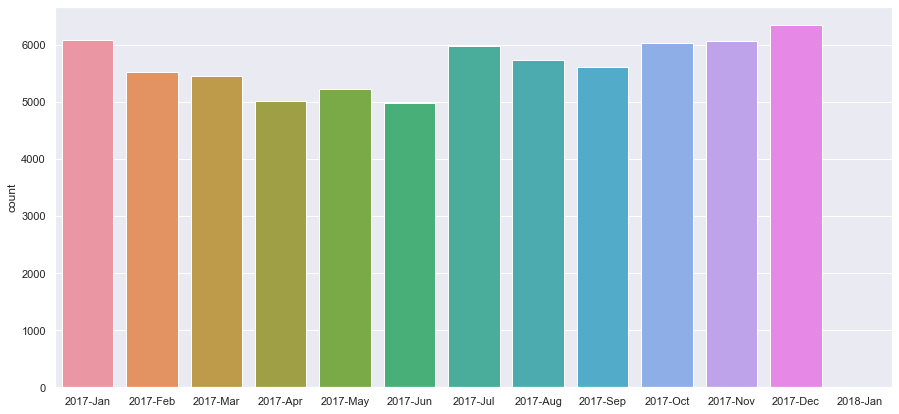

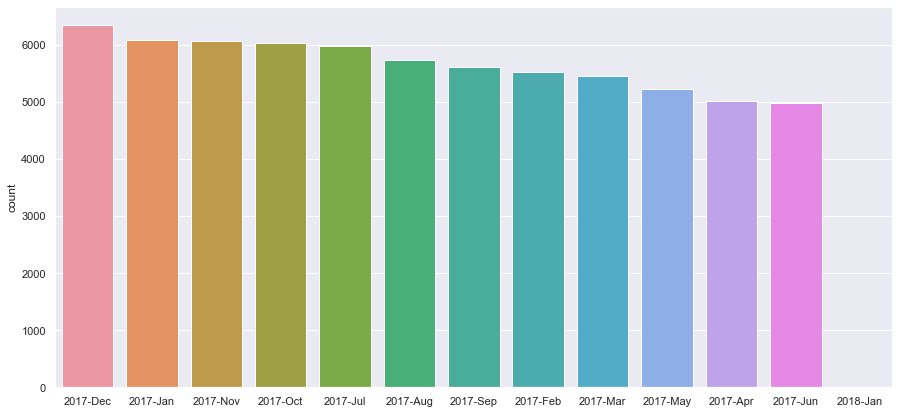

In [37]:
# Chronological order plot
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
sns.barplot(data=data, x=ym.index, y=ym['count'], ax=ax)

# Count order plot
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
_ = sns.barplot(x=ym['count'].sort_values(ascending=False).index, y=ym['count'].sort_values(ascending=False), ax=ax)

- Las fechas se encuentran casi exclusivamente en 2017, sólo hay 2 filas del 2018. Además, cada mes de 2017 tiene una cantidad de datos similar (~5000).
- Los peaks de vuelos se encuentran en diciembre y enero.

### 2.4.2 Días del mes

In [38]:
dm = data[['DIA']].groupby(data['DIA']).agg({'count'})['DIA']
dm

,count
DIA,
1,2204
2,2221
3,2263
4,2211
5,2234
6,2271
7,2260
8,2211
9,2222


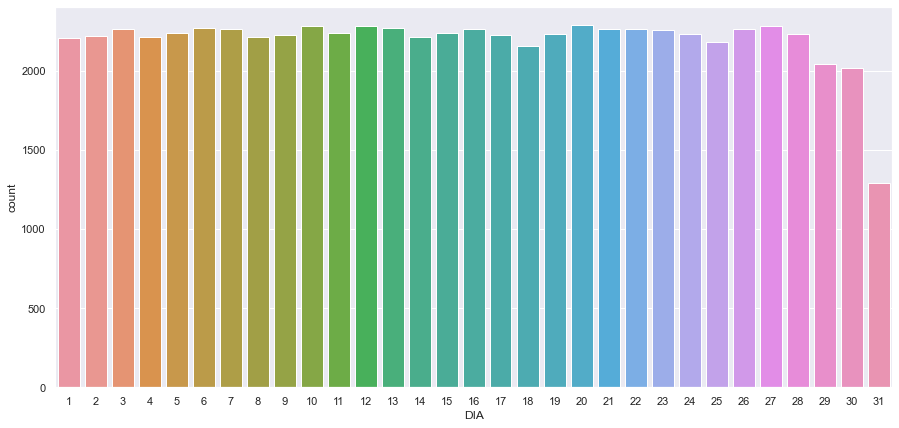

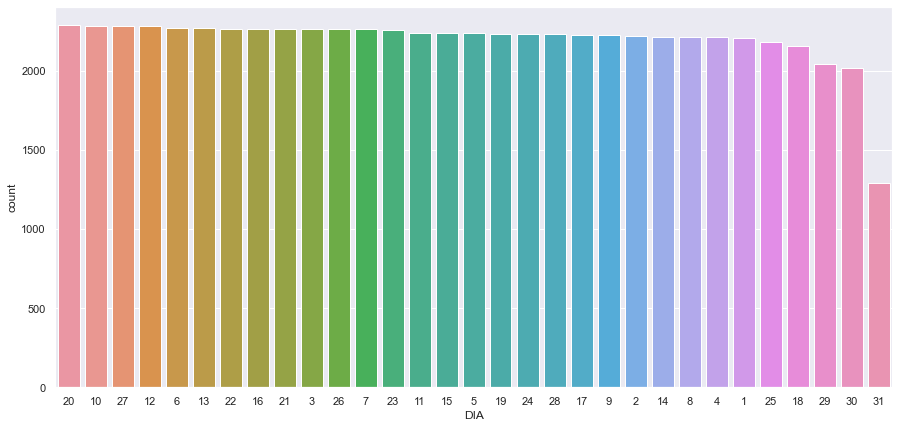

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
_ = sns.countplot(data=data, x='DIA', ax=ax)

fig, ax = plt.subplots(1, 1, figsize=(15, 7))
_ = sns.countplot(data=data, x='DIA', ax=ax, order=data['DIA'].value_counts().sort_values(ascending=False).index)

Se ve que la distribución por día del mes es similar, los días 29, 30 y 31 tienen menos cantidad de datos, pero esto se debe a que en un año hay menos meses que contienen esos días. Normalizando por la cantidad de días se puede ver la frecuencia real.

In [40]:
days = data[['DIA']].groupby(data['DIA']).agg({'count'})['DIA']
days.loc[1:28] = days.loc[1:28] / 12  # A year has 12 days from 1 to 28
days.loc[29:30] = days.loc[29:30] / 11  # A non-leap year has 11 days with number 29 and 30
days.loc[31] = days.loc[31] / 7  # A year has 7 days with a 31 date

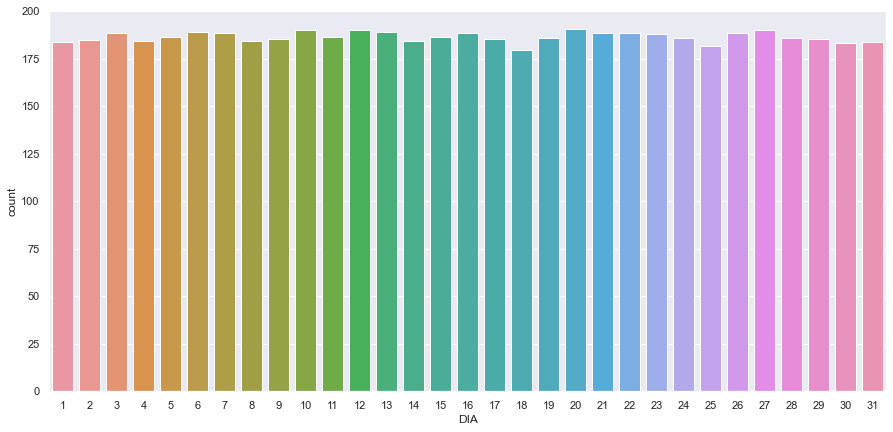

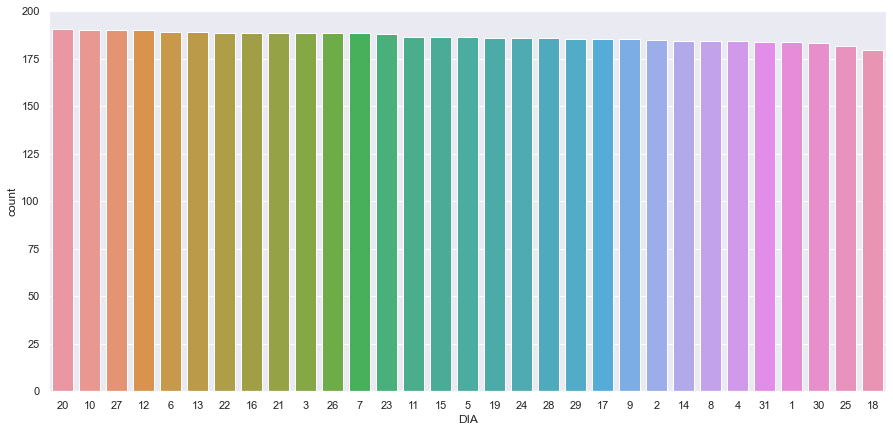

In [41]:
# Order by day
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
_ = sns.barplot(x=days.index, y=days['count'], ax=ax)

# Order by descending frequency
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
_ = sns.barplot(x=days.sort_values('count', ascending=False).index.astype(str),
                y=days.sort_values('count', ascending=False)['count'], ax=ax)

Acá se ve que la distribución por día es similar también para los últimos días del mes

### 2.4.3 Días de la semana

In [42]:
dw = data[['DIANOM']].groupby(data['DIANOM']).agg({'count'})['DIANOM'].sort_values('count', ascending=False)
dw

,count
DIANOM,
Viernes,10270
Jueves,10231
Lunes,10119
Domingo,9783
Miercoles,9699
Martes,9641
Sabado,8339


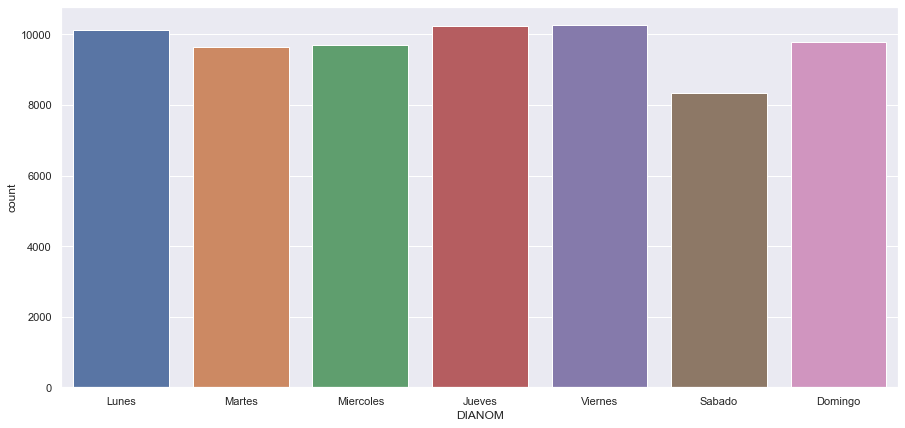

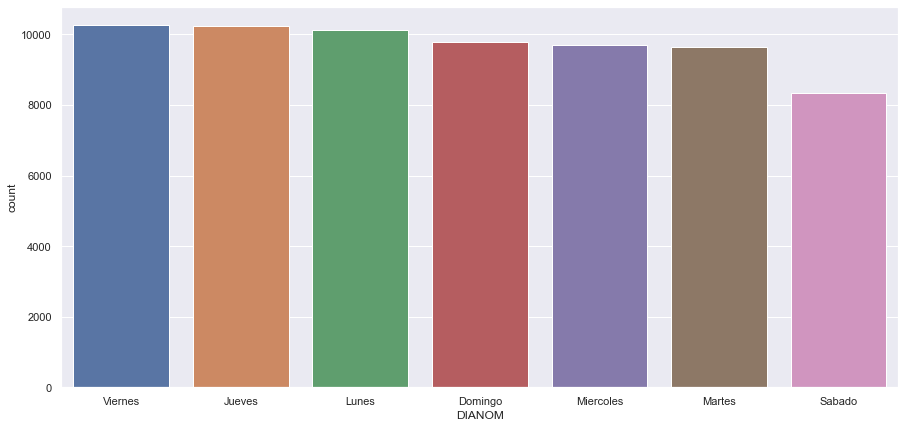

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
_ = sns.countplot(data=data, x='DIANOM', ax=ax, order=['Lunes', 'Martes', 'Miercoles', 'Jueves', 'Viernes',
                                                       'Sabado', 'Domingo'])

fig, ax = plt.subplots(1, 1, figsize=(15, 7))
_ = sns.countplot(data=data, x='DIANOM', ax=ax, order=dw.index)

El sábado tiene notoriamente menos vuelos.

### 2.4.4 Tipo de vuelo

In [44]:
ft = data[['TIPOVUELO']].groupby(data['TIPOVUELO']).agg({'count'})['TIPOVUELO'].sort_values('count', ascending=False)
ft

,count
TIPOVUELO,
N,36944
I,31138


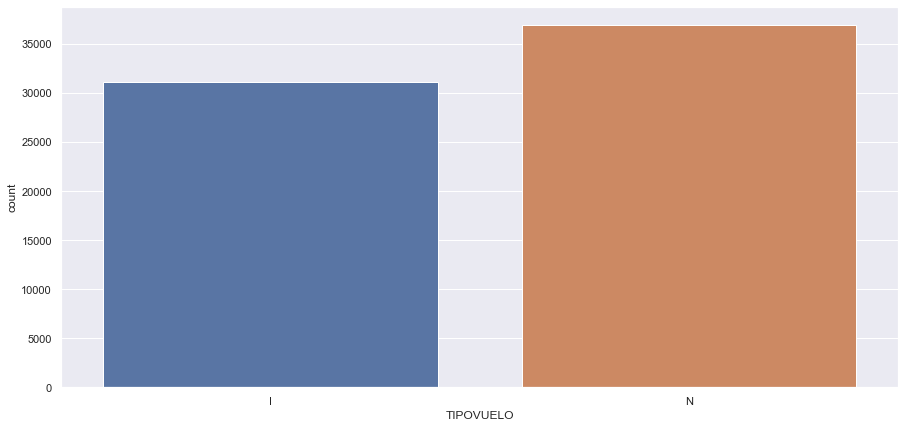

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
_ = sns.countplot(data=data, x='TIPOVUELO', ax=ax)

Hay más vuelos nacionales, pero ambos tipos de vuelo están dentro de los 30k-40k datos.

### 2.4.5 Aerolíneas

In [46]:
air = data[['OPERA']].groupby(data['OPERA']).agg({'count'})['OPERA'].sort_values('count', ascending=False)
air['percent'] = air['count'] / len(data) * 100
air['cumulative_percent'] = air['percent'].cumsum()
air

,count,percent,cumulative_percent
OPERA,,,
Grupo LATAM,40813,59.946829,59.946829
Sky Airline,14291,20.990864,80.937693
Aerolineas Argentinas,1948,2.861256,83.798948
Copa Air,1849,2.715843,86.514791
Latin American Wings,1656,2.432361,88.947152
Avianca,1150,1.689140,90.636292
JetSmart SPA,1094,1.606886,92.243177
Gol Trans,805,1.182398,93.425575
American Airlines,757,1.111894,94.537470


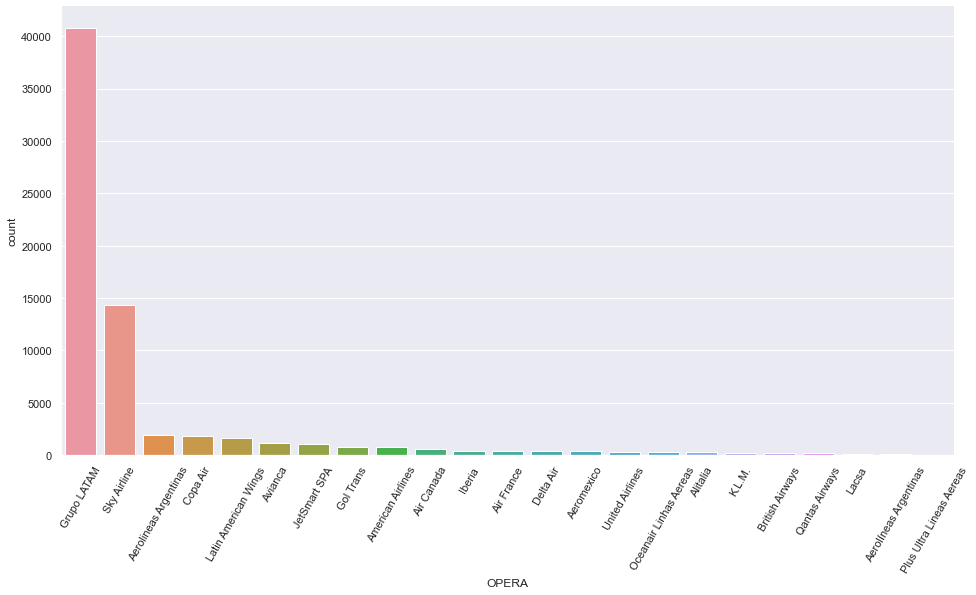

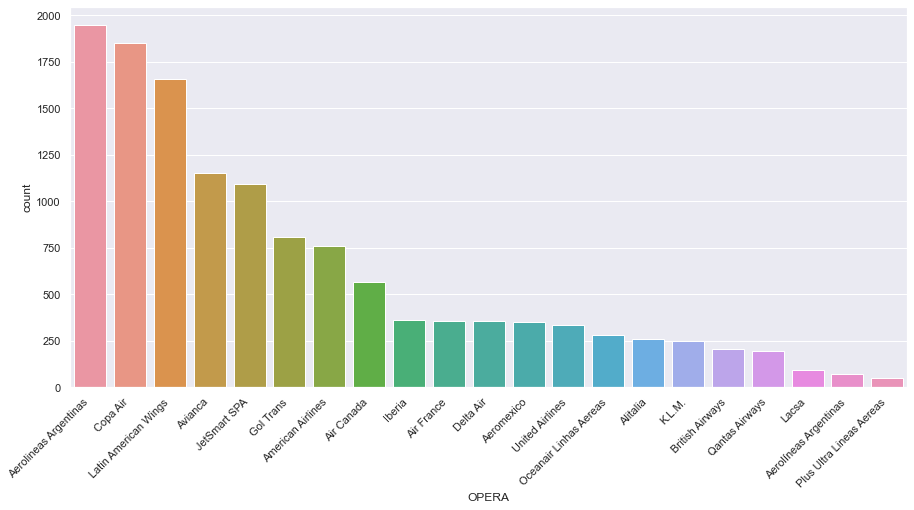

In [47]:
ax = sns.catplot(x='OPERA', kind='count', data=data, height=7, aspect=2, order=data['OPERA'].value_counts().index)

_ = ax.set_xticklabels(rotation=60)

# Second plot without the airlines with most flights
opera = data[['OPERA']].groupby(data['OPERA']).agg({'count'})['OPERA'].sort_values('count', ascending=False).iloc[2:]
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
sns.barplot(x=opera.index, y=opera['count'], ax=ax)
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

Las principales aerolíneas son LATAM y Sky.

### 2.4.6 Destinos

In [48]:
des = data[['SIGLADES']].groupby(data['SIGLADES']).agg({'count'})['SIGLADES'].sort_values('count', ascending=False)
des['percent'] = des['count'] / len(data) * 100
des['cumulative_percent'] = des['percent'].cumsum()
des.iloc[:16]

,count,percent,cumulative_percent
SIGLADES,,,
Buenos Aires,6276,9.218296,9.218296
Antofagasta,5786,8.498575,17.716871
Lima,5247,7.706883,25.423754
Calama,5145,7.557064,32.980817
Puerto Montt,4350,6.389354,39.370171
Concepcion,3989,5.859111,45.229282
Iquique,3746,5.502189,50.731471
Sao Paulo,3569,5.242208,55.973679
Temuco,2583,3.793954,59.767633


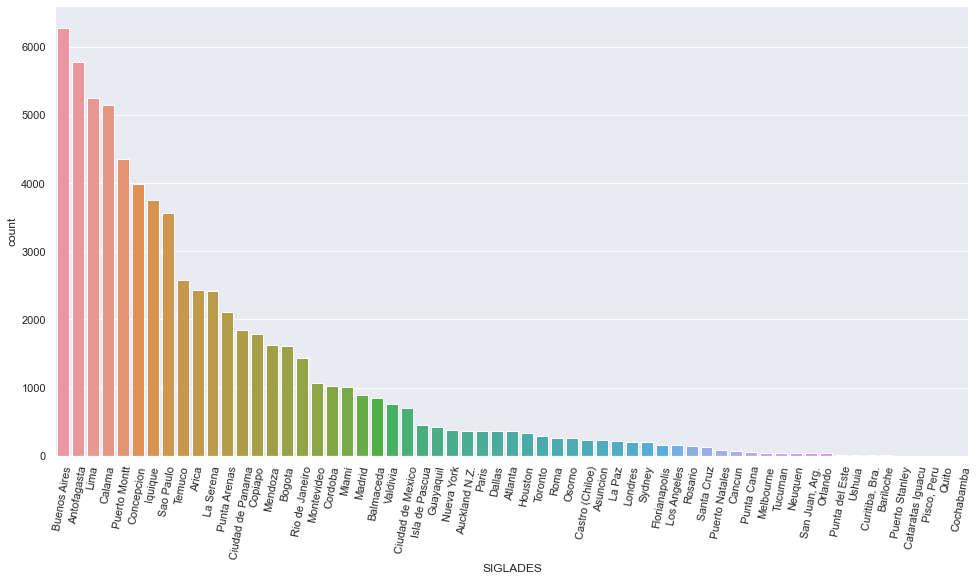

In [49]:
ax = sns.catplot(x='SIGLADES', kind='count', data=data, height=7, aspect=2, order=data['SIGLADES'].value_counts().index)
_ = ax.set_xticklabels(rotation=80)

La mayor cantidad de vuelos se centran en vuelos a Buenos Aires, Lima y ciudades nacionales.

In [50]:
data['lat'] = data['Des-O'].apply(get_data_by_icao, key='lat', codes=airport_codes_fix)
data['lon'] = data['Des-O'].apply(get_data_by_icao, key='lon', codes=airport_codes_fix)

In [51]:
def geoplot(data: pd.DataFrame) -> folium.Map:
    """
    Plot map with flight cities locations.
    :param data: Dataframe with geographic data (lat, lon) for each city.
    :return: Folium map object.
    """
    sw = data[['lat', 'lon']].min().values.tolist()
    ne = data[['lat', 'lon']].max().values.tolist()

    f_map = folium.Map(tiles="Stamen Terrain")
    f_map.fit_bounds([sw, ne])

    # cluster locations so map doesn't get cluttered
    marker_cluster = folium.plugins.MarkerCluster().add_to(f_map)

    # draw each station
    for i, row in data.iterrows():
        iframe = folium.IFrame(f"Airport: {row['airport_o']}, City: {row['city_o']}")
        popup = folium.Popup(iframe, min_width=200, max_width=300)
        folium.Marker([row['lat'], row['lon']],
                      popup=popup,
                      icon=folium.Icon(icon='circle',
                                       prefix='fa')).add_to(marker_cluster)
    return f_map


df = data[['airport_o', 'city_o', 'lat', 'lon']].drop_duplicates('city_o')
geoplot(data=df)

Go to File -> Trust Notebook to see the plot above.

Los destinos se encuentran en Sudamérica, Norteamérica, Europa y Oceanía, siendo estos últimos 3 los menos frecuentados.

# 3. Columnas sintéticas 

## 3.1 Temporada alta

In [52]:
def is_peak_season(date: datetime.datetime) -> int:
    """
    Check whether input date is peak season or not.
    :param date: Input date.
    :return: 1 if date is peak season, 0 otherwise.
    """
    peaks = {'1': {'start': datetime.datetime(date.year, 1, 1),
                   'stop': datetime.datetime(date.year, 3, 3, 23, 59, 59)},
             '2': {'start': datetime.datetime(date.year, 7, 15),
                   'stop': datetime.datetime(date.year, 7, 31, 23, 59, 59)},
             '3': {'start': datetime.datetime(date.year, 9, 11),
                   'stop': datetime.datetime(date.year, 9, 30, 23, 59, 59)},
             '4': {'start': datetime.datetime(date.year, 12, 15),
                   'stop': datetime.datetime(date.year, 12, 31, 23, 59, 59)}}
    for v in peaks.values():
        if v['start'] <= date <= v['stop']:
            return 1
    return 0

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,...,airport_i,city_o,airport_o,airport_name_i,airport_name_o,airline_i,airline_o,lat,lon,temporada_alta
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,...,Miami International Airport,Miami,Miami International Airport,Miami International Airport,Miami International Airport,American Airlines,American Airlines,25.7932,-80.290604,1
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,...,Miami International Airport,Miami,Miami International Airport,Miami International Airport,Miami International Airport,American Airlines,American Airlines,25.7932,-80.290604,1
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,...,Miami International Airport,Miami,Miami International Airport,Miami International Airport,Miami International Airport,American Airlines,American Airlines,25.7932,-80.290604,1
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,...,Miami International Airport,Miami,Miami International Airport,Miami International Airport,Miami International Airport,American Airlines,American Airlines,25.7932,-80.290604,1
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,...,Miami International Airport,Miami,Miami International Airport,Miami International Airport,Miami International Airport,American Airlines,American Airlines,25.7932,-80.290604,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68201,2017-12-22 14:55:00,400,SCEL,SPJC,JAT,2017-12-22 15:41:00,400,SCEL,SPJC,JAT,...,Jorge Chavez International Airport,Lima,Jorge Chavez International Airport,Jorge Chavez International Airport,Jorge Chavez International Airport,JetSMART,JetSMART,-12.0219,-77.114304,1
68202,2017-12-25 14:55:00,400,SCEL,SPJC,JAT,2017-12-25 15:11:00,400,SCEL,SPJC,JAT,...,Jorge Chavez International Airport,Lima,Jorge Chavez International Airport,Jorge Chavez International Airport,Jorge Chavez International Airport,JetSMART,JetSMART,-12.0219,-77.114304,1
68203,2017-12-27 14:55:00,400,SCEL,SPJC,JAT,2017-12-27 15:35:00,400,SCEL,SPJC,JAT,...,Jorge Chavez International Airport,Lima,Jorge Chavez International Airport,Jorge Chavez International Airport,Jorge Chavez International Airport,JetSMART,JetSMART,-12.0219,-77.114304,1
68204,2017-12-29 14:55:00,400,SCEL,SPJC,JAT,2017-12-29 15:08:00,400,SCEL,SPJC,JAT,...,Jorge Chavez International Airport,Lima,Jorge Chavez International Airport,Jorge Chavez International Airport,Jorge Chavez International Airport,JetSMART,JetSMART,-12.0219,-77.114304,1


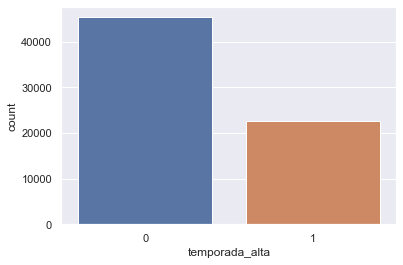

In [53]:
data['temporada_alta'] = data['Fecha-O'].apply(lambda x: is_peak_season(x))
sns.countplot(data=data, x='temporada_alta')
data

## 3.2 Diferencia de tiempos

In [54]:
data['dif_min'] = (data['Fecha-O'] - data['Fecha-I']) / pd.Timedelta(1, 'm')

## 3.3 Atraso de 15 minutos

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,...,airport_o,airport_name_i,airport_name_o,airline_i,airline_o,lat,lon,temporada_alta,dif_min,atraso_15
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,...,Miami International Airport,Miami International Airport,Miami International Airport,American Airlines,American Airlines,25.7932,-80.290604,1,3.0,0
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,...,Miami International Airport,Miami International Airport,Miami International Airport,American Airlines,American Airlines,25.7932,-80.290604,1,9.0,0
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,...,Miami International Airport,Miami International Airport,Miami International Airport,American Airlines,American Airlines,25.7932,-80.290604,1,9.0,0
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,...,Miami International Airport,Miami International Airport,Miami International Airport,American Airlines,American Airlines,25.7932,-80.290604,1,3.0,0
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,...,Miami International Airport,Miami International Airport,Miami International Airport,American Airlines,American Airlines,25.7932,-80.290604,1,-2.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68201,2017-12-22 14:55:00,400,SCEL,SPJC,JAT,2017-12-22 15:41:00,400,SCEL,SPJC,JAT,...,Jorge Chavez International Airport,Jorge Chavez International Airport,Jorge Chavez International Airport,JetSMART,JetSMART,-12.0219,-77.114304,1,46.0,1
68202,2017-12-25 14:55:00,400,SCEL,SPJC,JAT,2017-12-25 15:11:00,400,SCEL,SPJC,JAT,...,Jorge Chavez International Airport,Jorge Chavez International Airport,Jorge Chavez International Airport,JetSMART,JetSMART,-12.0219,-77.114304,1,16.0,1
68203,2017-12-27 14:55:00,400,SCEL,SPJC,JAT,2017-12-27 15:35:00,400,SCEL,SPJC,JAT,...,Jorge Chavez International Airport,Jorge Chavez International Airport,Jorge Chavez International Airport,JetSMART,JetSMART,-12.0219,-77.114304,1,40.0,1
68204,2017-12-29 14:55:00,400,SCEL,SPJC,JAT,2017-12-29 15:08:00,400,SCEL,SPJC,JAT,...,Jorge Chavez International Airport,Jorge Chavez International Airport,Jorge Chavez International Airport,JetSMART,JetSMART,-12.0219,-77.114304,1,13.0,0


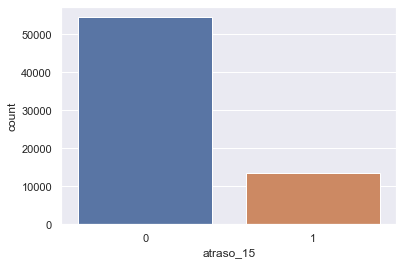

In [55]:
data['atraso_15'] = (data['dif_min'] >= 15).astype(int)
sns.countplot(data=data, x='atraso_15')
data

## 3.3 Periodo del día

In [56]:
def get_day_period(date: datetime.datetime) -> str:
    """
    Check day period of a given date.
    :param date: Input date.
    :return: String indicating the day period, either 'mañana' (morning), 'tarde' (evening) or 'noche' (night).
    """
    if 5 <= date.hour <= 11:
        return 'mañana'
    elif 12 <= date.hour <= 18:
        return 'tarde'
    return 'noche'

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,...,airport_name_i,airport_name_o,airline_i,airline_o,lat,lon,temporada_alta,dif_min,atraso_15,periodo_dia
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,...,Miami International Airport,Miami International Airport,American Airlines,American Airlines,25.7932,-80.290604,1,3.0,0,noche
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,...,Miami International Airport,Miami International Airport,American Airlines,American Airlines,25.7932,-80.290604,1,9.0,0,noche
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,...,Miami International Airport,Miami International Airport,American Airlines,American Airlines,25.7932,-80.290604,1,9.0,0,noche
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,...,Miami International Airport,Miami International Airport,American Airlines,American Airlines,25.7932,-80.290604,1,3.0,0,noche
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,...,Miami International Airport,Miami International Airport,American Airlines,American Airlines,25.7932,-80.290604,1,-2.0,0,noche
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68201,2017-12-22 14:55:00,400,SCEL,SPJC,JAT,2017-12-22 15:41:00,400,SCEL,SPJC,JAT,...,Jorge Chavez International Airport,Jorge Chavez International Airport,JetSMART,JetSMART,-12.0219,-77.114304,1,46.0,1,tarde
68202,2017-12-25 14:55:00,400,SCEL,SPJC,JAT,2017-12-25 15:11:00,400,SCEL,SPJC,JAT,...,Jorge Chavez International Airport,Jorge Chavez International Airport,JetSMART,JetSMART,-12.0219,-77.114304,1,16.0,1,tarde
68203,2017-12-27 14:55:00,400,SCEL,SPJC,JAT,2017-12-27 15:35:00,400,SCEL,SPJC,JAT,...,Jorge Chavez International Airport,Jorge Chavez International Airport,JetSMART,JetSMART,-12.0219,-77.114304,1,40.0,1,tarde
68204,2017-12-29 14:55:00,400,SCEL,SPJC,JAT,2017-12-29 15:08:00,400,SCEL,SPJC,JAT,...,Jorge Chavez International Airport,Jorge Chavez International Airport,JetSMART,JetSMART,-12.0219,-77.114304,1,13.0,0,tarde


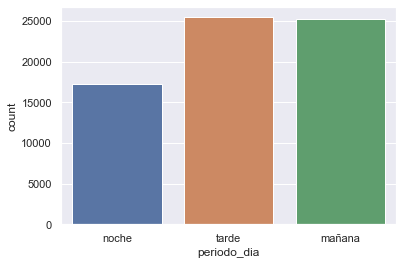

In [57]:
data['periodo_dia'] = data['Fecha-I'].apply(get_day_period)
sns.countplot(data=data, x='periodo_dia')
data

Hay menos vuelos de noche

## 3.4 Guardar columnas nuevas

In [58]:
data_synth = data[['temporada_alta', 'atraso_15', 'periodo_dia']]
data_synth.to_csv(Path().joinpath('data', 'synthetic_features.csv'), index=False)

# 4. Tasa de atraso por columnas
## 4.1 Destino

In [59]:
def get_col_distribution(data: pd.DataFrame, col: str) -> pd.DataFrame:
    """
    Calculate delay ratio for a given variable.
    :param data: Dataset including delay column ('atraso_15') and categorical columns.
    :param col: Dataset column for which to calculate delay ratio.
    :return: DataFrame with delay data for the column.
    """
    df_delay = data[[col, 'atraso_15']].groupby(col).agg(['sum', 'count', 'mean', 'std'])['atraso_15']
    df_delay.reset_index(inplace=True)
    df_delay.sort_values('mean', inplace=True, ascending=False)  # Mean represents the delay rate
    df_delay[:60].sort_values('mean', ascending=False)
    return df_delay


def get_col_dist_plots(data: pd.DataFrame, col: str) -> pd.DataFrame:
    """
    Calculate delay ratio for a given variable. Show barplots for each category of the variable.
    :param data: Dataset including delay column ('atraso_15') and categorical columns.
    :param col: Dataset column for which to calculate delay ratio.
    :return: DataFrame with delay data for the column.
    """
    df_delay = get_col_distribution(data, col)
    # Order bars by descending delay rate
    fig, ax = plt.subplots(figsize=(15, 7))
    sns.barplot(data=data, x=col, y='atraso_15', ax=ax, order=df_delay[col])
    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=60, horizontalalignment='right')

    # Order bars by descending frequency
    fig, ax = plt.subplots(figsize=(15, 7))
    sns.barplot(data=data, x=col, y='atraso_15', ax=ax, order=df_delay.sort_values('count', ascending=False)[col])
    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=60, horizontalalignment='right')
    return df_delay

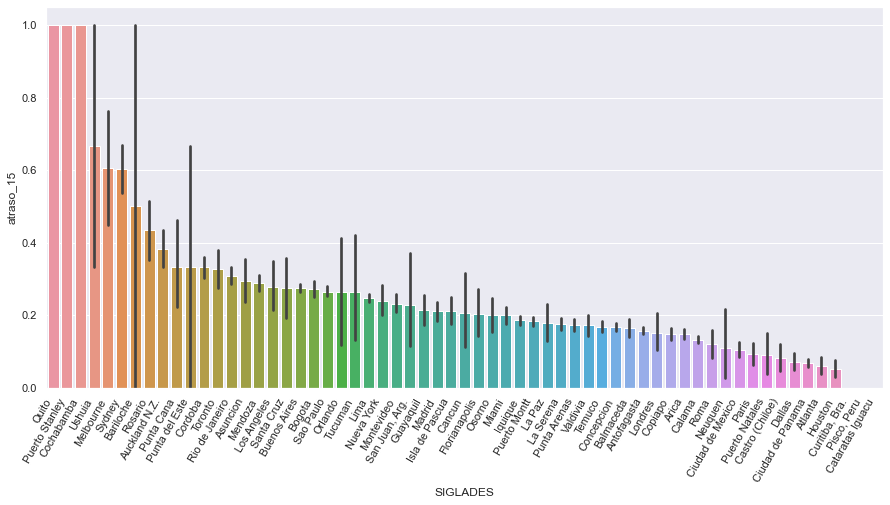

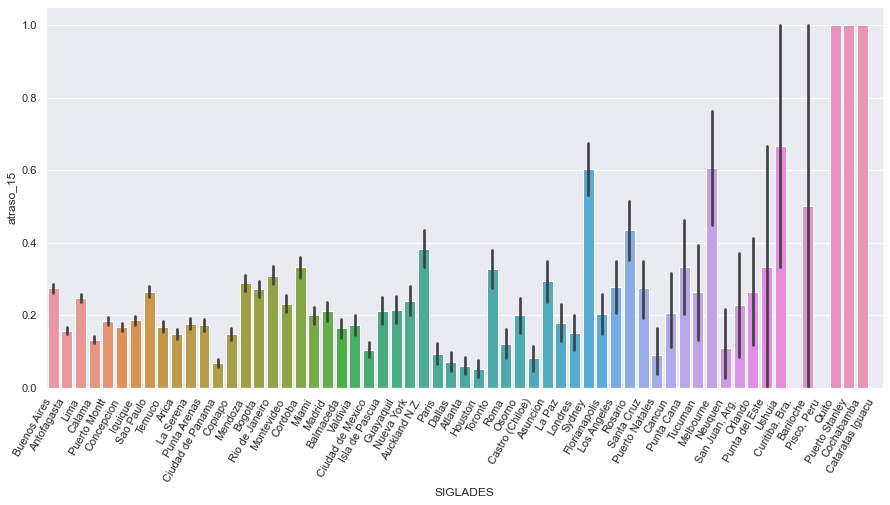

In [60]:
des_delay = get_col_dist_plots(data, 'SIGLADES')

Hay algunos destinos con muy pocos datos que tienen una tasa de 1, lo cual no sería representativo. Lo mismo pasa al revés, ciudades con cero tasa de atraso pero con un dato. En el segundo gráfico es notorio que a medida que se tienen menos datos el atraso es mayor y la varianza se dispara (o es nula para ciudades de un solo dato).

De todas formas la tasa de atraso se mueve entre 15% y 40% en general.

In [61]:
data.loc[(data['SIGLADES'] == 'Quito') |
         (data['SIGLADES'] == 'Puerto Stanley') |
         (data['SIGLADES'] == 'Cochabamba')]  # Ciudades con mayor tasa de atraso por tener solo un dato

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,...,airport_name_i,airport_name_o,airline_i,airline_o,lat,lon,temporada_alta,dif_min,atraso_15,periodo_dia
17061,2017-03-23 01:00:00,1906,SCEL,SEQM,LNE,2017-03-23 01:24:00,1906,SCEL,SEQM,LNE,...,Nuevo Aeropuerto Internacional Mariscal Sucre,Nuevo Aeropuerto Internacional Mariscal Sucre,Aerolane,Aerolane,-0.129167,-78.357500,0,24.0,1,noche
61213,2017-11-08 07:45:00,1257,SCEL,EGYP,LAN,2017-11-08 08:35:00,1257,SCEL,EGYP,LAN,...,Mount Pleasant Airport,Mount Pleasant Airport,LATAM Chile,LATAM Chile,-51.822800,-58.447201,0,50.0,1,mañana
67692,2017-12-10 00:01:00,1238,SCEL,SLCB,LAN,2017-12-10 01:54:00,1238,SCEL,SLCB,LAN,...,Jorge Wilsterman International Airport,Jorge Wilsterman International Airport,LATAM Chile,LATAM Chile,-17.421101,-66.177101,0,113.0,1,noche


In [62]:
data.loc[(data['SIGLADES'] == 'Curitiba, Bra.') |
         (data['SIGLADES'] == 'Pisco, Peru') |
         (data['SIGLADES'] == 'Cataratas Iguacu')]  # Ciudades con menor tasa de atraso por tener pocos datos

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,...,airport_name_i,airport_name_o,airline_i,airline_o,lat,lon,temporada_alta,dif_min,atraso_15,periodo_dia
1219,2017-01-03 07:15:00,9782,SCEL,SBFI,TAM,2017-01-03 07:20:00,9782,SCEL,SBFI,TAM,...,Cataratas International Airport,Cataratas International Airport,LATAM Brasil,LATAM Brasil,-25.600279,-54.485001,1,5.0,0,mañana
17059,2017-03-08 06:20:00,1351,SCEL,SBCT,LAN,2017-03-08 06:10:00,1351,SCEL,SBCT,LAN,...,Afonso Pena Airport,Afonso Pena Airport,LATAM Chile,LATAM Chile,-25.528500,-49.175800,0,-10.0,0,mañana
17060,2017-03-06 14:20:00,1357,SCEL,SBCT,LAN,2017-03-06 14:26:00,1357,SCEL,SBCT,LAN,...,Afonso Pena Airport,Afonso Pena Airport,LATAM Chile,LATAM Chile,-25.528500,-49.175800,0,6.0,0,tarde
39316,2017-08-10 20:15:00,8541,SCEL,SBCT,ONE,2017-08-10 20:11:00,8541,SCEL,SBCT,ONE,...,Afonso Pena Airport,Afonso Pena Airport,Avianca Brasil,Avianca Brasil,-25.528500,-49.175800,0,-4.0,0,noche
55363,2017-10-12 15:30:00,1241,SCEL,SPSO,LAN,2017-10-12 15:32:00,1241,SCEL,SPSO,LAN,...,Capitan FAP Renan Elias Olivera International ...,Capitan FAP Renan Elias Olivera International ...,LATAM Chile,LATAM Chile,-13.744900,-76.220299,0,2.0,0,tarde


Por lo anterior quitaré las ciudades que tengan una sola fila de datos.

In [63]:
data.loc[data['SIGLADES'].isin(des_delay.loc[des_delay['std'].isna()]['SIGLADES'])]

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,...,airport_name_i,airport_name_o,airline_i,airline_o,lat,lon,temporada_alta,dif_min,atraso_15,periodo_dia
1219,2017-01-03 07:15:00,9782,SCEL,SBFI,TAM,2017-01-03 07:20:00,9782,SCEL,SBFI,TAM,...,Cataratas International Airport,Cataratas International Airport,LATAM Brasil,LATAM Brasil,-25.600279,-54.485001,1,5.0,0,mañana
17061,2017-03-23 01:00:00,1906,SCEL,SEQM,LNE,2017-03-23 01:24:00,1906,SCEL,SEQM,LNE,...,Nuevo Aeropuerto Internacional Mariscal Sucre,Nuevo Aeropuerto Internacional Mariscal Sucre,Aerolane,Aerolane,-0.129167,-78.357500,0,24.0,1,noche
55363,2017-10-12 15:30:00,1241,SCEL,SPSO,LAN,2017-10-12 15:32:00,1241,SCEL,SPSO,LAN,...,Capitan FAP Renan Elias Olivera International ...,Capitan FAP Renan Elias Olivera International ...,LATAM Chile,LATAM Chile,-13.744900,-76.220299,0,2.0,0,tarde
61213,2017-11-08 07:45:00,1257,SCEL,EGYP,LAN,2017-11-08 08:35:00,1257,SCEL,EGYP,LAN,...,Mount Pleasant Airport,Mount Pleasant Airport,LATAM Chile,LATAM Chile,-51.822800,-58.447201,0,50.0,1,mañana
67692,2017-12-10 00:01:00,1238,SCEL,SLCB,LAN,2017-12-10 01:54:00,1238,SCEL,SLCB,LAN,...,Jorge Wilsterman International Airport,Jorge Wilsterman International Airport,LATAM Chile,LATAM Chile,-17.421101,-66.177101,0,113.0,1,noche


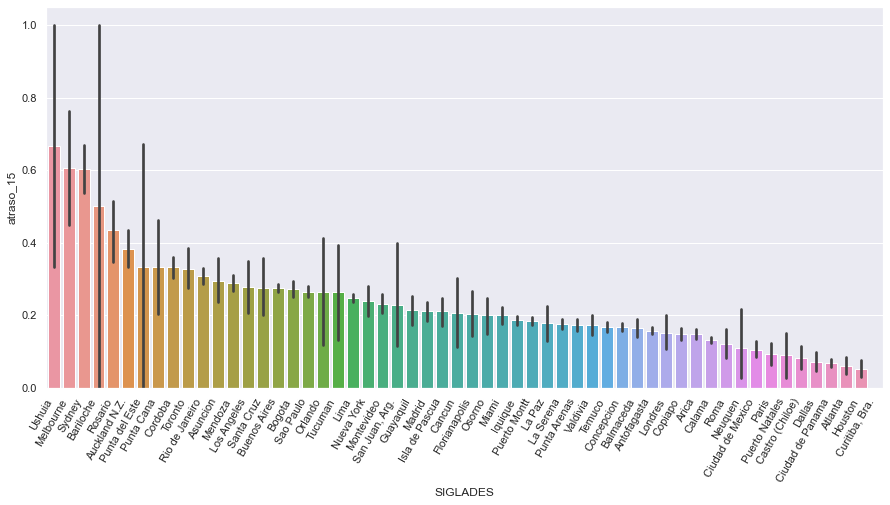

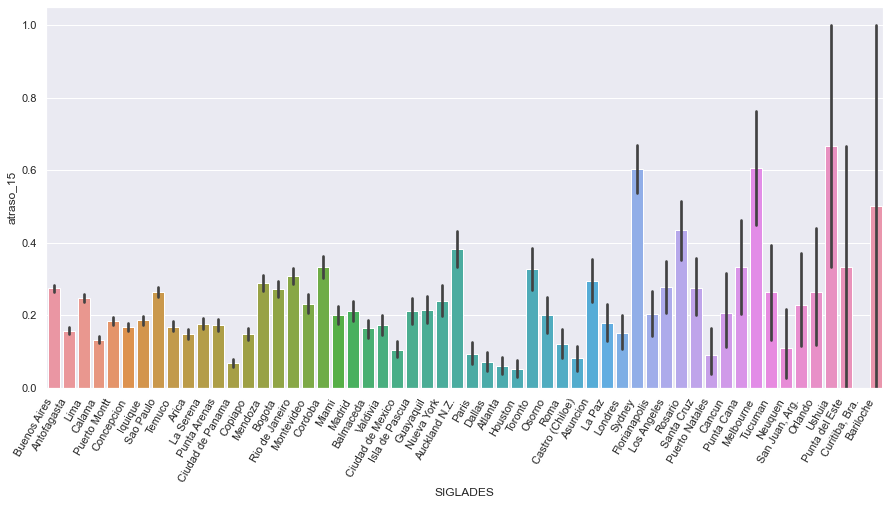

In [64]:
data = data.loc[~data['SIGLADES'].isin(des_delay.loc[des_delay['std'].isna()]['SIGLADES'])]
des_delay = get_col_dist_plots(data, 'SIGLADES')

## 4.2 Aerolínea

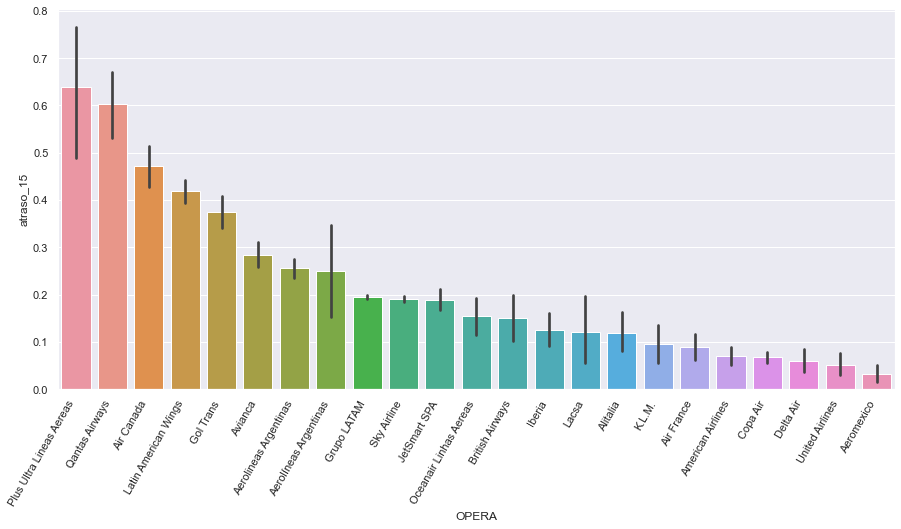

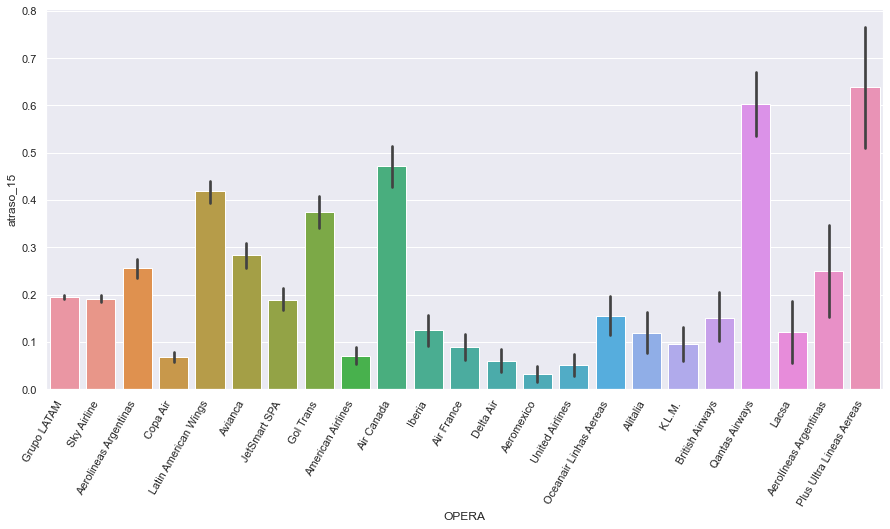

In [65]:
airline_delay = get_col_dist_plots(data, 'OPERA')

Las aerolíneas con más vuelos tienden a tener menor atraso.

## 4.3 Mes

In [66]:
month_delay = data[['MES', 'atraso_15']].groupby('MES').agg(['sum', 'count', 'mean', 'std'])['atraso_15']
month_delay.reset_index(inplace=True)
month_delay.sort_values('mean', inplace=True, ascending=False)
month_delay.loc[:, 'month_name'] = pd.to_datetime(month_delay['MES'], format='%m').dt.month_name().str.slice(stop=3)
data.loc[:, 'month_name'] = pd.to_datetime(data['MES'], format='%m').dt.month_name().str.slice(stop=3)
month_delay

C:\Users\Admin\AppData\Local\Temp\ipykernel_11460\3821616820.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, 'month_name'] = pd.to_datetime(data['MES'], format='%m').dt.month_name().str.slice(stop=3)


,MES,sum,count,mean,std,month_name
6,7,1867,5979,0.312260,0.463454,Jul
11,12,1721,6348,0.271109,0.444567,Dec
9,10,1466,6030,0.243118,0.429001,Oct
10,11,1295,6074,0.213204,0.409604,Nov
7,8,1071,5738,0.186650,0.389665,Aug
8,9,1046,5608,0.186519,0.389560,Sep
5,6,924,4978,0.185617,0.388836,Jun
0,1,1072,6092,0.175968,0.380825,Jan
4,5,895,5227,0.171226,0.376743,May
1,2,882,5529,0.159523,0.366196,Feb


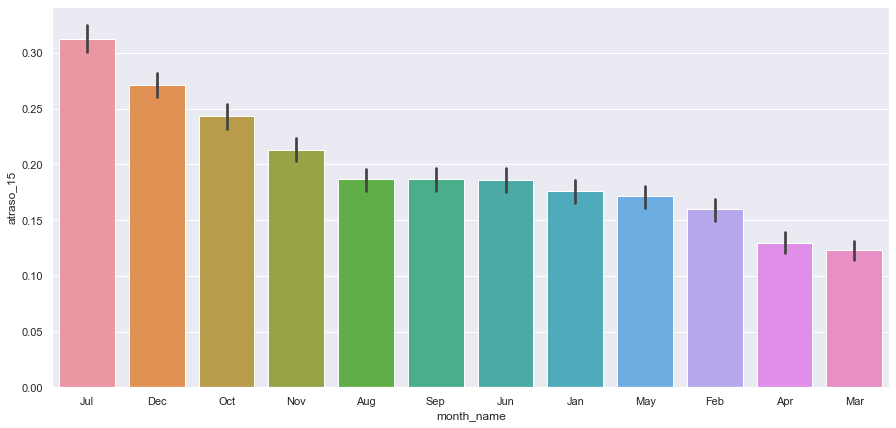

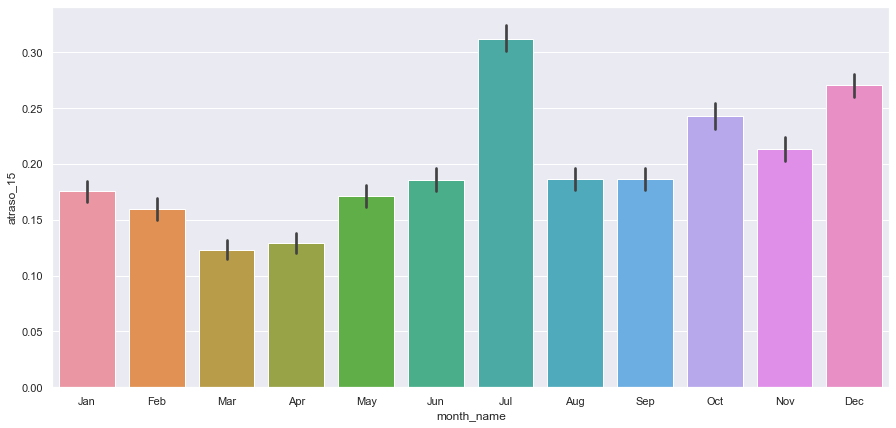

In [67]:
# Plot by delay rate order
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
sns.barplot(data=data, x='month_name', y='atraso_15', ax=ax, order=month_delay['month_name'])

# Plot by month order
month_delay.sort_values('MES', inplace=True)
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
_ = sns.barplot(data=data, x='month_name', y='atraso_15', ax=ax, order=month_delay['month_name'])

Las mayores tasas de atraso se dan en julio y diciembre, en temporada alta con una tasa de atraso entre 25-30%. Además en todos los meses la tasa no baja del 10%.

## 4.4 Tipo de vuelo

In [68]:
flight_type_delay = data[['TIPOVUELO', 'atraso_15']].groupby('TIPOVUELO').agg(['sum', 'count', 'mean', 'std'])[
    'atraso_15']
flight_type_delay.reset_index(inplace=True)
flight_type_delay.sort_values('mean', inplace=True, ascending=False)
flight_type_delay

,TIPOVUELO,sum,count,mean,std
0,I,7527,31133,0.241769,0.428162
1,N,6033,36944,0.163301,0.369645


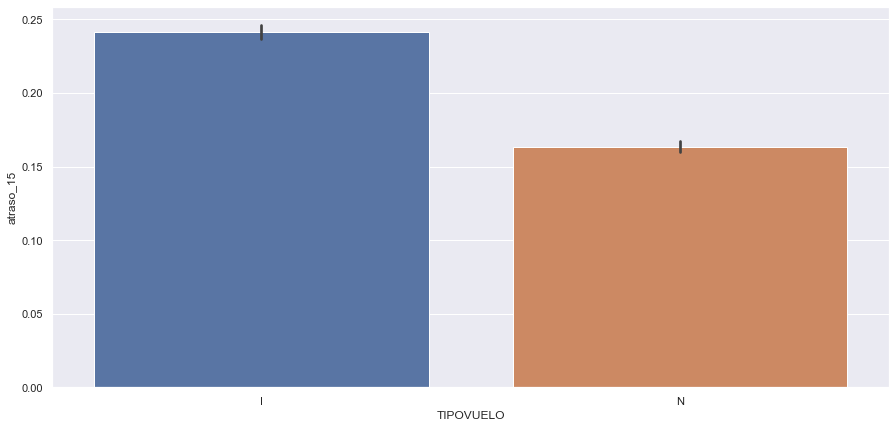

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
_ = sns.barplot(data=data, x='TIPOVUELO', y='atraso_15', ax=ax)

La tasa de atraso es considerablemente menor en vuelos nacionales, esto es esperable ya que en aeropuertos nacionales hay menos vuelos y menos aerolíneas que en aeropuertos internacionales por lo que hay menos desafíos logísticos. Además hay que considerar que el aeropuerto más grande que es el de Santiago no está en los datos (no hay destino Santiago).

## 4.5 Temporada alta

In [70]:
peak_delay = data[['temporada_alta', 'atraso_15']].groupby('temporada_alta').agg(['sum', 'count', 'mean', 'std'])[
    'atraso_15']
peak_delay.reset_index(inplace=True)
peak_delay.sort_values('mean', inplace=True, ascending=False)
peak_delay

,temporada_alta,sum,count,mean,std
1,1,4782,22698,0.210679,0.407800
0,0,8778,45379,0.193437,0.394997


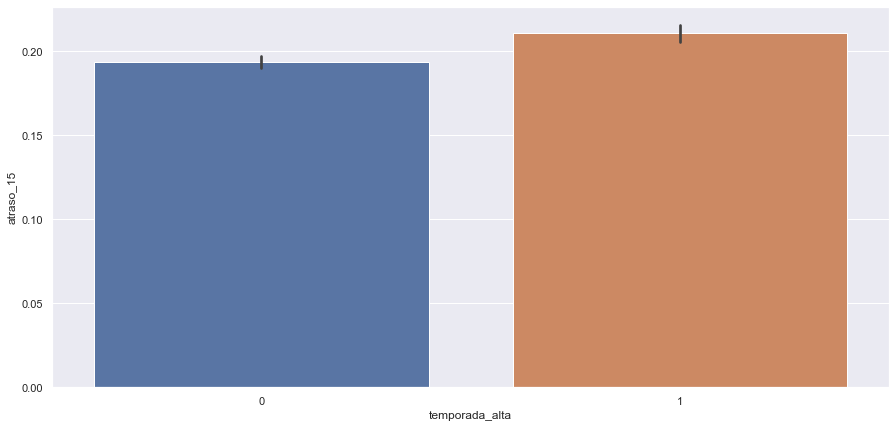

In [71]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
_ = sns.barplot(data=data, x='temporada_alta', y='atraso_15', ax=ax)

Los atrasos son mayores en temporada alta, sobre el 20%. Esto es esperable ya que el hecho de que haya más vuelos implica más problemas logísticos en general (capacidad de pasajeros por avión, disponibilidad de aviones, pistas de aterrizaje, etc).

## 4.6 Período del día

In [72]:
period_delay = data[['periodo_dia', 'atraso_15']].groupby('periodo_dia').agg(['sum', 'count', 'mean', 'std'])[
    'atraso_15']
period_delay.reset_index(inplace=True)
period_delay.sort_values('mean', inplace=True, ascending=False)
period_delay

,periodo_dia,sum,count,mean,std
2,tarde,5474,25476,0.214869,0.410739
1,noche,3689,17297,0.213274,0.409631
0,mañana,4397,25304,0.173767,0.378916


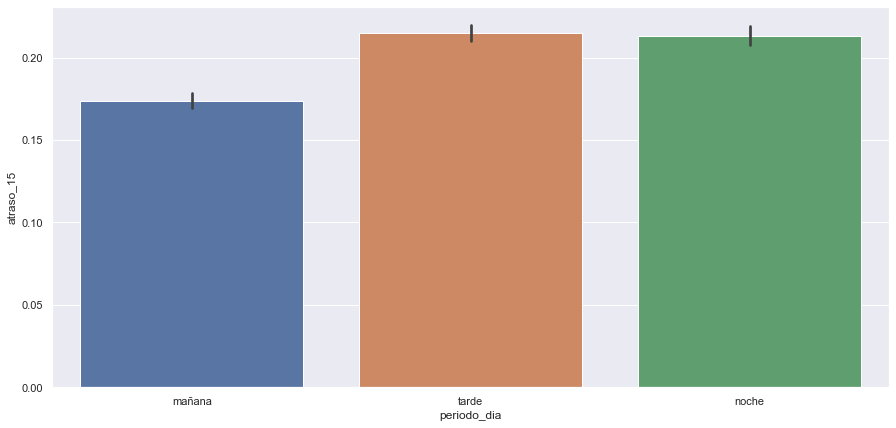

In [73]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
_ = sns.barplot(data=data, x='periodo_dia', y='atraso_15', ax=ax, order=['mañana', 'tarde', 'noche'])

Los vuelos de mañana tienden a tener menor cantidad de atrasos. Esto tiene sentido desde un punto de vista operacional, ya que si la operación funciona por día, los atrasos se van acarreando a medida que pasa el tiempo, es decir si hubo un atraso en la mañana, probablemente desncadene más retrasos el resto del día.

# 5. Resumen EDA
**1. ¿Cómo se distribuyen los datos? ¿Qué te llama la atención o cuál es tu conclusión sobre esto?**


- La única ciudad de origen es Santiago.


- Existen algunos datos inconsistentes entre programación y operación en particular para número de vuelo y destino, esto puede deberse a cambios en los itinerarios, algunos vuelos llegan a una ciudad pero a un aeropuerto distinto, otros van directamente a otro destino. Dado que en total estas inconsistencias son infrecuentes (123 filas), se eliminan.


- También hay inconsistencias en las aerolíneas, pero se debe a que en muchos casos una misma aerolínea tiene sucursales regionales o servicios específicos (e.g. servicio express) por lo que se agendan para la aerolínea en general pero en la operación se toma una sucursal en concreto. Además se dan casos donde una misma aerolínea tiene nombres alternativos o antiguos, por lo que se supone que la operadora es la de programación.


- Los datos son a lo largo de todo 2017, solo dos filas son de 2018. Cada mes tiene datos de un orden de magnitud similar por lo que la distribución de las variables debería estar bien representada en los datos que se tienen.


- Los meses con más vuelos son Julio, Octubre, Noviembre, Diciembre y Enero. Los de menor demanda son abril y junio.


- No hay días del mes que sean escogidos particularmente para los vuelos, esto tiene sentido ya que el número en sí no es relevante en comparación al día de la semana, feriados en el año o coordinación de días de vacaciones.
    
    
- Los días de la semana más frecuentes son viernes, jueves y lunes. El menos frecuente es sábado, esto puede deberse a que para aprovechar los fines de semana los viajeros prefieren llegar antes del sábado a su destino. Por esa misma razón jueves y viernes son más frecuentes, ya que se anticipan al fin de semana. El día lunes podría ser frecuente para viajes más largos (de semanas enteras). También habría que tener en consideración los patrones de precio que podrían influenciar qué día se agendan vuelos.

    
    
- Los vuelos nacionales son más frecuentes. De todas formas tanto nacional como internacional tienen una cantidad de datos dentro del mismo orden de magnitud.
    
    
- Las principales aerolíneas son Grupo LATAM y Sky Airlines concentrando el 81% del dataset.
    
    
- Los principales destinos son ciudades de Chile en general, y algunas ciudades de Latinoamérica (Buenos Aires, Lima, Sao Paulo, Ciudad de Panamá, Bogotá). El destino más frecuente es Buenos Aires. Los vuelos a Norteamérica, Europa y Oceanía son menos frecuentes.

- Adicionalmente, si bien los datos que se tienen presentan ciertos patrones, hay información que podría ser relevante a la hora de predecir y que no está en el dataset:
    1. Variables ambientales: El tiempo tanto de origen como de destino puede afectar los atrasos, por ejemplo si hay lluvia o nieve toda la logística se hace más lenta.
    2. Variables por avión: Saber el ID del avión podría ser útil ya que, si un avión tiene varios vuelos consecutivos (por ejemplo) un atraso en el primer vuelo generará atrasos en todos los subsiguientes, específcamente una variable que indique la cantidad de vuelos de un avión para ese día podría servir. Además el saber la antiguedad del avión también puede ser un indicador ya que uno más antiguo requerirá mantenimientos más frecuentes.

**3). ¿Cómo se compone la tasa de atraso por destino, aerolínea, mes del año, día de la semana, temporada, tipo de vuelo?
¿Qué variables esperarías que más influyeran en predecir atrasos?**

    
 - Algunos destinos tienen pocos datos, lo que genera tasas de atraso extremas (0 o 1) así que estas se eliminan. En general los destinos con menos datos tienen una mayor tasa de atraso y dispersión, esto puede indicar que la distribución no está bien representada. Se ve que la tasa de atraso es heterogénea, por lo que cada destino tiene una distribución característica.
 
 
 - El comportamiento es similar al anterior. Además se ve que las aerolíneas más comunes son las mejores con baja tasa de atraso y dispersión.
 

- Para los meses se ve una separación por grupos de meses, julio y diciembre son más altos (coincidean con temporada alta) mientras que abril y mayo son bastante bajos. Es decir a mayor demanda aumenta la tasa de atraso.


- El tipo de vuelo diferencia la tasa de atraso, siendo más alta para vuelos internacionales, esto también se puede desprender al ver la tasa de atraso por destino, por lo que podría ser redundante.


- Temporada alta no genera una gran separación en los datos, esto se debe a que Septiembre es temporada alta pero la tasa de atraso en ese mes no es particularmente alta.


- Los vuelos de mañana tienden a tener menor cantidad de atrasos. Esto tiene sentido desde un punto de vista operacional, ya que si la operación funciona por día, los atrasos se van acarreando a medida que pasa el tiempo, es decir si hubo un atraso en la mañana, probablemente desncadene más retrasos el resto del día.



- Según los gráficos que se mostraron anteriormente, las variables que más muestran una separación para los atrasos son el periodo del día (mañana vs tarde/noche), tipo de vuelo y mes del año.
 

# 6. Modelamiento
## 6.1 Preparar dataset

Primero guardaré el dataset original con las limpiezas previas. En base a los comentarios anteriores y a las columnas que son redundantes o irrelevantes, se mantendrán las columnas MES, DIANOM, TIPOVUELO, OPERA y SIGLADES.

- Vlo se descarta, Des y Emp son redundantes con SIGLADES y OPERA por lo que se mantienen las últimas.

- AÑO es innecesario ya que la data es de un solo año, además con Fecha-I está de manera implícita.

- atraso_15 es la variable a predecir, por lo que no son necesarias dif_min, Fecha-O y Fecha-I ya que solo sirven para el cálculo de atraso_15.

- Las variables que creé para revisar datos de aerolíneas o aeropuertos también se eliminan (airline_i, city_i, etc)


*Las columnas MES y DIANOM se pueden obtener desde la fecha pero las conservo por comodidad para no hacer esas transformaciones después.*

In [74]:
cols = ['MES', 'DIANOM', 'TIPOVUELO', 'OPERA', 'SIGLADES']
data[cols].to_csv(Path().joinpath('data', 'dataset_SCL_clean.csv'), index=False)
data_synth = data[['temporada_alta', 'atraso_15', 'periodo_dia']]
data_synth.to_csv(Path().joinpath('data', 'synthetic_features.csv'), index=False)

In [75]:
# Recreate dataset from clean data and synthetic features
df = pd.read_csv(Path().joinpath('data', 'dataset_SCL_clean.csv'))
df_synth = pd.read_csv(Path().joinpath('data', 'synthetic_features.csv'))
df = pd.concat([df, df_synth], axis=1)
df = df.convert_dtypes()  # Cast object to str where possible
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68077 entries, 0 to 68076
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   MES             68077 non-null  Int64 
 1   DIANOM          68077 non-null  string
 2   TIPOVUELO       68077 non-null  string
 3   OPERA           68077 non-null  string
 4   SIGLADES        68077 non-null  string
 5   temporada_alta  68077 non-null  Int64 
 6   atraso_15       68077 non-null  Int64 
 7   periodo_dia     68077 non-null  string
dtypes: Int64(3), string(5)
memory usage: 4.3 MB


In [76]:
df['atraso_15'].mean()

0.19918621560879593

Cerca del 20% de los datos corresponden a vuelos atrasados, las clases están desbalanceadas, pero tampoco es un caso extremo.

**Columnas categóricas a int/onehot**

In [77]:
x = df.drop(columns='atraso_15')
y = df['atraso_15'].astype(int)

label_encs = {}
for c in x.columns:
    label_encs[c] = LabelEncoder().fit(x[c])  # Store objects in case I want to do inverse transform later
    x[c] = label_encs[c].transform(x[c])

# One-hot encoding
x_oh = pd.get_dummies(df.drop(columns='atraso_15'),
                      columns=['MES', 'DIANOM', 'TIPOVUELO', 'OPERA', 'SIGLADES', 'temporada_alta',
                               'periodo_dia'])

In [78]:
x

,MES,DIANOM,TIPOVUELO,OPERA,SIGLADES,temporada_alta,periodo_dia
0,0,0,0,6,32,1,1
1,0,2,0,6,32,1,1
2,0,3,0,6,32,1,1
3,0,4,0,6,32,1,1
4,0,1,0,6,32,1,1
...,...,...,...,...,...,...,...
68072,11,6,0,14,26,1,2
68073,11,2,0,14,26,1,2
68074,11,4,0,14,26,1,2
68075,11,6,0,14,26,1,2


In [79]:
x_oh

,MES_1,MES_2,MES_3,MES_4,MES_5,MES_6,MES_7,MES_8,MES_9,MES_10,...,SIGLADES_Temuco,SIGLADES_Toronto,SIGLADES_Tucuman,SIGLADES_Ushuia,SIGLADES_Valdivia,temporada_alta_0,temporada_alta_1,periodo_dia_mañana,periodo_dia_noche,periodo_dia_tarde
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68072,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
68073,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
68074,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
68075,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1


## 6.2 Entrenar modelos

Por restricción de tiempo no haré optimización de hiperparámetros, pero si tuviera más tiempo haría grid searching o algún proceso similar. Además usaré modelos relativamente sencillos para no demorarme demasiado en entrenarlos.

In [80]:
x_train, x_test, y_train, y_test = train_test_split(x_oh, y, test_size=.2, random_state=33)

In [81]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(54461, 105)
(54461,)
(13616, 105)
(13616,)


### Logistic Regression

In [82]:
lr = LogisticRegressionCV(max_iter=1000).fit(x_train, y_train)

### Multi Layer Perceptron

In [83]:
mlp = MLPClassifier(hidden_layer_sizes=(10, 10, 10), random_state=1, max_iter=300).fit(x_train, y_train)

###  Light Gradient Boosting Machine

In [84]:
# LGBM handles onehot encoding internally, so x_oh is not used, but x instead
x_train_, x_test_, y_train_, y_test_ = train_test_split(x, y, test_size=.2, random_state=33)
train_data = lgbm.Dataset(x_train_, label=y_train_,
                          categorical_feature=['MES', 'DIANOM', 'TIPOVUELO', 'OPERA', 'SIGLADES',
                                               'temporada_alta', 'periodo_dia'])
param = {'num_leaves': 31, 'objective': 'binary'}
param['metric'] = ['auc', 'binary_logloss']
num_round = 10
bst = lgbm.LGBMClassifier(learning_rate=0.09, max_depth=-5, random_state=42)
_ = bst.fit(x_train_, y_train_)

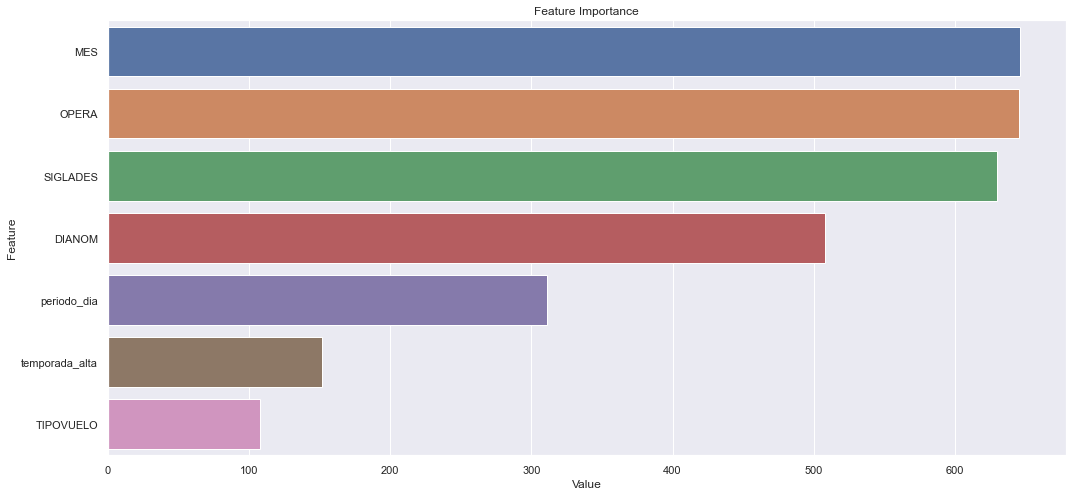

In [85]:
feature_imp = pd.DataFrame(sorted(zip(bst.feature_importances_, x_train_.columns)), columns=['Value', 'Feature'])

plt.figure(figsize=(15, 7))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Feature Importance')
plt.tight_layout()

Las columnas más importantes serían mes, aerolínea y destino., mientras que la temporada y el tipo de vuelo no afectan demasiado.

## 6.3 Resultados
### 6.3.1 Cálculo de resultados

In [86]:
def show_results(clf, x: pd.DataFrame, y: pd.Series, verbose: bool = True) -> None:
    """
    Show prediction results of a classifier object for data x and labels y.
    :param clf: Classifier object (alredy trained).
    :param x: Input data.
    :param y: Labels.
    :param verbose: Whether to show whole report or only most important metrics
    """
    y_pred_p = clf.predict_proba(x)
    y_pred = clf.predict(x)
    df_cm = pd.DataFrame(confusion_matrix(y, y_pred))
    df_cm.index = ['Real On Time', 'Real Delay']
    df_cm.columns = ['Predicted On Time', 'Predicted Delay']
    df_summary = pd.DataFrame.from_dict(classification_report(y, y_pred, output_dict=True))
    auc = roc_auc_score(y, y_pred_p[:, 1])
    if verbose:
        print('--CONFUSION MATRIX')
        print(df_cm)
        print('--CLASSIFICATION REPORT')
        print(df_summary)
        print(f'--AUC: {auc}\n')
    return [auc, df_summary.iloc[0, 2], *df_summary['weighted avg'].loc[['precision', 'recall', 'f1-score']].values.tolist()]


        
models = {}
models['logreg'] = lr
models['mlp'] = mlp
models['lgbm'] = bst

verbose = False

df_results = pd.DataFrame(columns=['set', 'model', 'auc', 'accuracy', 'precision', 'recall', 'f1-score'])
for k, v in models.items():
    if k != 'lgbm':
        df_results.loc[len(df_results)] = ['train', k, *show_results(v, x_train, y_train, verbose=verbose)]
        df_results.loc[len(df_results)] = ['test', k, *show_results(v, x_test, y_test, verbose=verbose)]
    else:
        df_results.loc[len(df_results)] = ['train', k, *show_results(v, x_train_, y_train_, verbose=verbose)]
        df_results.loc[len(df_results)] = ['test', k, *show_results(v, x_test_, y_test_, verbose=verbose)]
# Test results
df_results

,set,model,auc,accuracy,precision,recall,f1-score
0,train,logreg,0.678299,0.803401,0.764370,0.803401,0.725192
1,test,logreg,0.674541,0.798840,0.743213,0.798840,0.717452
2,train,mlp,0.733717,0.813298,0.783207,0.813298,0.764752
3,test,mlp,0.695556,0.803687,0.763311,0.803687,0.752490
4,train,lgbm,0.736065,0.812930,0.794234,0.812930,0.751521
5,test,lgbm,0.705105,0.806551,0.777435,0.806551,0.742645


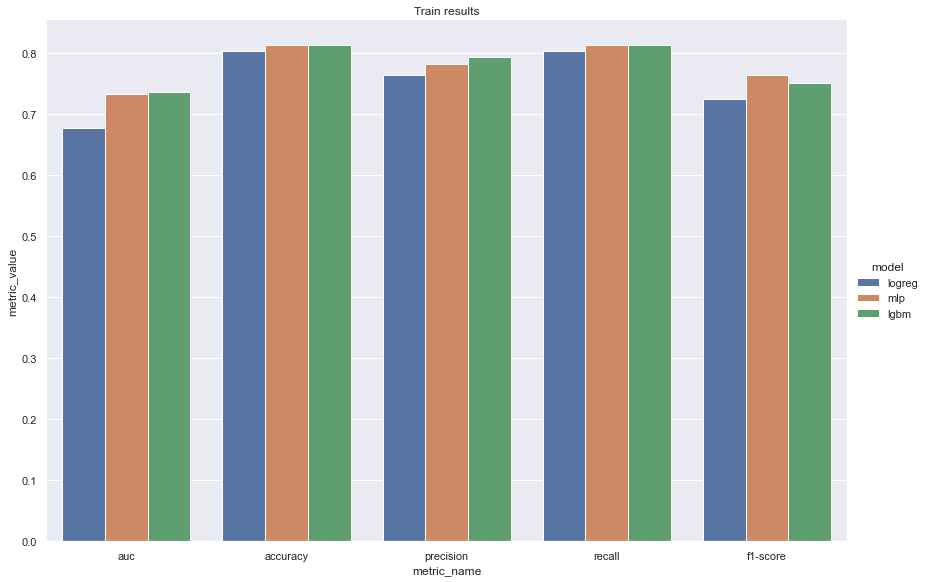

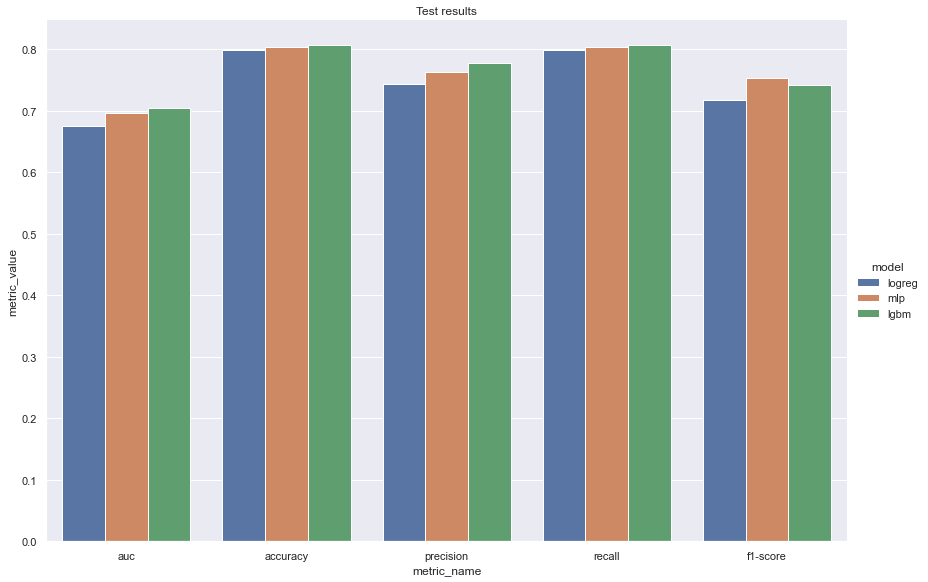

In [87]:
df = pd.melt(df_results.loc[df_results['set'] == 'train'],
             id_vars=["model", "set"], var_name="metric_name", value_name="metric_value")
_ = sns.catplot(x='metric_name', y='metric_value', hue='model', data=df, kind='bar', height=8, aspect=1.5)
plt.title('Train results')
df = pd.melt(df_results.loc[df_results['set'] == 'test'],
             id_vars=["model", "set"], var_name="metric_name", value_name="metric_value")
_ = sns.catplot(x='metric_name', y='metric_value', hue='model', data=df, kind='bar', height=8, aspect=1.5)
_ = plt.title('Test results')

Recordemos que las clases son desbalanceadas, cerca del 20% de datos son de atraso, mientras que le 80% restante son vuelos a tiempo. Dado que nos interesa más optimizar los resultados sobre atraso, las métricas de precision, recall y f1-score que se muestran son para la clase atraso (atraso_15 = 1).

### 6.4.2 Análisis de resultados
**Evalúa tu modelo. ¿Qué performance tiene? ¿Qué métricas usaste para evaluar esa performance y por qué? ¿Por qué
elegiste ese algoritmo en particular? ¿Qué variables son las que más influyen en la predicción? ¿Cómo podrías mejorar la
performance?**


- Como se ve en el gráfico, medir accuracy no es una buena métrica pues los tres modelos tienen un desmpeño similar, cercano al 80% que justamente corresponde a la proporción de la clase mayoritaria. Un modelo que simplemente fuera random.random() > 0.8 tendría el mismo accuracy.


- El resto de métricas nos sirven más para comprender el desmpeño de los modelos, en particular el AUC Y F1-score. Este última específicamente es útil cuando se tienen clases desbalanceadas pues tiene en cuenta precision y recall.


- Se observa que la MLP y LGBM funcionan mejor, en particular MPL consigue el f1-score mayor de 0.75. No obstante, LGBM tiene mejor AUC, por lo que podría decirse que el desmpeño de ambos modelos es similar, aunque LGBM tiene la ventaja de entregar la importancia de las columnas. De todas formas, estos resultados no son mucho mejores que la regresión logística.


- La regresión logística la elegí porque es de los modelos más sencillos (otra opción podría ser navie bayes) y sirve para tener un baseline y no partir usando un modelo excesivamente complejo. LightGBM lo utilicé porque me permite además de clasificar, obtener la importancia de las variables, lo cual puede ser útil para feature engineering. En particular se obtiene el mes, aerolínea y destino son las más importantes. Finalmente, probé redes neuronales pues son altamente optimizables, el modelo se puede complejizar y bastante con distintas arquitecturas y usando grid searching (no tuve tiempo de hacerlo ahora).


- Una forma de mejorar el modelo sería agregando nuevas columnas, una que podría ser obtenible son las condiciones meteorológicas del destino. Además, como se mencionó antes, hacer feature selection con LightGBM para luego alimentar otro modelo podría mejorar el desempeño, otra opción sería reducir y transformar variables usand PCA. En esta línea, se podría probar un ensamble de modelos, en vez de entrenar modelos independientes.

In [88]:
# Show more complete results
verbose = True

for k, v in models.items():
    print(f'MODEL: {k}')
    if k != 'lgbm':
        print(f'-TRAIN')
        show_results(v, x_train, y_train, verbose=verbose)
        print(f'-TEST')
        show_results(v, x_test, y_test, verbose=verbose)
    else:
        print(f'-TRAIN')
        show_results(v, x_train_, y_train_, verbose=verbose)
        print(f'-TEST')
        show_results(v, x_test_, y_test_, verbose=verbose)
    print('-' * 50)

MODEL: logreg
-TRAIN
--CONFUSION MATRIX
              Predicted On Time  Predicted Delay
Real On Time              43416              227
Real Delay                10480              338
--CLASSIFICATION REPORT
                      0             1  accuracy     macro avg  weighted avg
precision      0.805551      0.598230  0.803401      0.701891      0.764370
recall         0.994799      0.031244  0.803401      0.513021      0.803401
f1-score       0.890229      0.059387  0.803401      0.474808      0.725192
support    43643.000000  10818.000000  0.803401  54461.000000  54461.000000
--AUC: 0.6782993203901093

-TEST
--CONFUSION MATRIX
              Predicted On Time  Predicted Delay
Real On Time              10816               58
Real Delay                 2681               61
--CLASSIFICATION REPORT
                      0            1  accuracy     macro avg  weighted avg
precision      0.801363     0.512605   0.79884      0.656984      0.743213
recall         0.994666     0.022247